# Forecasting Food Prices in Ethiopia

Principal data sources:
1. Ethiopia Food Prices Dataset from the World Food Programme Price Database, offering extensive food price data across Ethiopia.
2. Ethiopia Food Prices Dataset from the Famine Early Warning Systems Network,

Supplementary data sources:
1. Ethiopia Food Category Prices from the FAO [https://www.fao.org/worldfoodsituation/foodpricesindex/en/]
2. WFP Global Market Monitor, updated weekly [https://data.humdata.org/dataset/global-market-monitor]
3. Ethiopia Monthly Rainfall Data from WFP | CHIRPS [https://data.humdata.org/dataset/eth-rainfall-subnational]
4. Ethiopia Population Dataset from OCHA [https://data.humdata.org/dataset/cod-ps-eth]
5. Conflict in Ethiopia Dataset from the Armed Conflict Location & Event Data Project (ACLED), containing detailed records of conflict events [https://data.humdata.org/dataset/ethiopia-acled-conflict-data]

Other datasets to add:
1. Ethiopia Crop Production Statistics from Data Kimetrica, providing detailed statistics on crop production []
2. US Dollar — Ethiopian Birr Historical Data []
3. Anommoly hotspots [https://data.humdata.org/dataset/asap-hotspots-monthly]


In [ ]:
import io
import re
import os
import numpy as np
import pandas as pd
import requests
from datetime import date, timedelta
from hdx.data.dataset import Dataset
from hdx.api.configuration import Configuration
from pathlib import Path

pd.set_option('display.max_rows', None)

/Users/nataschajademinnitt/mamba/envs/foodsec/lib/python3.11/site-packages/ckanapi/version.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
# ------------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------------
os.chdir('/Users/nataschajademinnitt/Documents/5_data/food_security/')

REQUEST_TIMEOUT = 90
USER_AGENT = {"User-Agent": "Mozilla/5.0 (foodsec-notebook/0.2)"}

Configuration.create(
    hdx_site="prod",
    user_agent="ethiopia-foodsec-etl",
    hdx_read_only=True,
)

# Lookback horizon for price data (approx 5y + 1mo padding for leap years)
FIVE_YEARS_AGO_ISO = (date.today() - timedelta(days=5*365 + 30)).isoformat()
FIVE_YEARS_AGO_TS  = (pd.Timestamp.today().normalize() - pd.offsets.DateOffset(years=5))

In [ ]:
# ------------------------------------------------------------------------------
# Basic helpers
# ------------------------------------------------------------------------------

def norm(s: str, *, lower=True, keep_internal_space=True) -> str:
    """Trim + collapse spaces; lowercase by default."""
    if s is None:
        return ""
    s = re.sub(r"\s+", " ", str(s).strip())
    return s.lower() if lower else s


def month_start(x):
    """Coerce to month-start Timestamp(s) for scalars, Series, or arrays."""
    obj = pd.to_datetime(x, errors="coerce")

    # Pandas Series → use .dt accessors
    if isinstance(obj, pd.Series):
        return obj.dt.to_period("M").dt.to_timestamp()

    # Numpy array / list → convert to Series then back
    if isinstance(obj, (np.ndarray, list, tuple)):
        ser = pd.to_datetime(pd.Series(obj), errors="coerce")
        return ser.dt.to_period("M").dt.to_timestamp().to_numpy()

    # Scalar (Timestamp/NaT) → use Timestamp methods
    if pd.isna(obj):
        return pd.NaT
    return pd.Timestamp(obj).to_period("M").to_timestamp()


def safe_numeric(sr: pd.Series) -> pd.Series:
    return pd.to_numeric(sr, errors="coerce")


# ------------------------------------------------------------------------------
# Product sets & mappings (focus foods only)
# ------------------------------------------------------------------------------

# Final set of products you care about in the panel/model
FOCUS_PRODUCTS = {
    "Maize Grain (White)",
    "Sorghum",
    "Wheat Grain",
    "Rice (Milled)",
    "Beans (Haricot)",
    "Wheat Flour",
    "Mixed Teff",
    "Refined sugar",
    "Refined Vegetable Oil"
}

# Canonical names we allow in the pipeline
FEWS_CANON = FOCUS_PRODUCTS

# Direct text → canonical

DIRECT_MAP = {
    # Maize
    "maize": "Maize Grain (White)",
    "maize (white)": "Maize Grain (White)",
    "white maize": "Maize Grain (White)",

    # Wheat
    "wheat": "Wheat Grain",
    "wheat (white)": "Wheat Grain",
    "wheat (mixed)": "Wheat Grain",
    "wheat flour": "Wheat Flour",

    # Rice
    "rice": "Rice (Milled)",
    "milled rice": "Rice (Milled)",

    # Beans
    "beans": "Beans (Haricot)",
    "haricot beans": "Beans (Haricot)",
    "haricot": "Beans (Haricot)",

    # Sorghum
    "sorghum": "Sorghum",
    "sorghum (white)": "Sorghum",
    "sorghum (red)": "Sorghum",
    "sorghum (yellow)": "Sorghum",

    # Oils and sugar
    "oil (vegetable)": "Refined Vegetable Oil",
    "vegetable oil": "Refined Vegetable Oil",
    "sugar": "Refined sugar",

    # Teff
    "teff (mixed)": "Mixed Teff",
    "teff (white)": "Mixed Teff",
    "teff (red)": "Mixed Teff",
    "teff (sergegna)": "Mixed Teff",
    "teff": "Mixed Teff",
}

# Regex mapping rules (for noisy WFP commodity text)

REGEX_RULES = [
    (r"^maize.*white", "Maize Grain (White)"),
    (r"^wheat.*flour", "Wheat Flour"),
    (r"^wheat\\b", "Wheat Grain"),
    (r"^rice\\b", "Rice (Milled)"),
    (r"^haricot\\b", "Beans (Haricot)"),
    (r"^sorghum.*(white|red|yellow)?", "Sorghum"),
    (r"^oil.*vegetable", "Refined Vegetable Oil"),
    (r"^vegetable oil", "Refined Vegetable Oil"),
    (r"^sugar", "Refined sugar"),
    (r"^teff", "Mixed Teff"),
]

# Main mapping function — lenient and robust

def map_wfp_product_to_fews(name: str) -> str | None:
    """
    Map raw commodity names into canonical FEWS-style names.
    Returns one of FOCUS_PRODUCTS (FEWS_CANON) or None if no match.
    """
    if pd.isna(name):
        return None

    s_raw = str(name)
    s = re.sub(r"\s+", " ", s_raw.strip().lower())

    # 1) Exact canonical match
    for canon in FEWS_CANON:
        if canon.lower() == s:
            return canon

    # 2) Direct lookup
    if s in DIRECT_MAP:
        target = DIRECT_MAP[s]
        return target if target in FEWS_CANON else None

    # 3) Regex matching
    for pat, target in REGEX_RULES:
        if re.search(pat, s):
            return target if target in FEWS_CANON else None

    # 4) Fuzzy fallback (keyword search)
    if "maize" in s and "white" in s:
        return "Maize Grain (White)"
    if "wheat" in s and "flour" in s:
        return "Wheat Flour"
    if "wheat" in s:
        return "Wheat Grain"
    if "rice" in s:
        return "Rice (Milled)"
    if "sorghum" in s:
        return "Sorghum"
    if "teff" in s:
        return "Mixed Teff"
    if "haricot" in s or "bean" in s:
        return "Beans (Haricot)"
    if "oil" in s and "vegetable" in s:
        return "Refined Vegetable Oil"
    if "sugar" in s:
        return "Refined sugar"

    # 5) No match
    return None

# ------------------------------------------------------------------------------
# Unit normalization
# ------------------------------------------------------------------------------

EXPECTED_UNIT = {
    "Maize Grain (White)": "kg",
    "Sorghum": "kg",
    "Wheat Grain": "kg",
    "Wheat Flour": "kg",
    "Rice (Milled)": "kg",
    "Beans (Haricot)": "kg",
    "Mixed Teff": "kg",
    "Refined sugar": "kg",
    "Refined Vegetable Oil": "l",
}


def normalize_unit_and_factor(u: str) -> tuple[str, float]:
    s = norm(u).replace(".", "")
    if s in {"kg","kgs","kilogram","kilograms"}:
        return "kg", 1.0
    if s in {"l","lt","ltr","litre","liter","litres","liters"}:
        return "l", 1.0
    if s in {"head","heads"}:
        return "head", 1.0
    if s in {"ea","each"}:
        return "ea", 1.0

    # e.g. '50 kg', '100 kg'
    m = re.match(r"^(\d+)\s*kg$", s)
    if m:
        qty = float(m.group(1))
        if qty > 0:
            return "kg", 1.0 / qty

    return s, 1.0


def normalize_wfp_units(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize WFP price units to match FEWSNET convention (mostly retail level).
    - Converts 100 KG and 50 KG prices to per-kg.
    - Renames units consistently (kg, l, ea, head).
    """
    df = df.copy()
    df["unit"] = df["unit"].astype(str).str.upper().str.strip()

    # Map common unit variants to a factor
    unit_factor = {
        "100 KG": 100.0,
        "50 KG": 50.0,
        "KG": 1.0,
        "KGS": 1.0,
        "L": 1.0,
        "LTR": 1.0,
        "HEAD": 1.0,
        "EA": 1.0,
    }

    # Apply conversion factor
    df["unit_factor"] = df["unit"].map(unit_factor).fillna(1.0)
    df["value"] = df["value"] / df["unit_factor"]

    # Normalize unit labels to FEWS-style (lowercase)
    df["unit"] = (
        df["unit"].replace({
            "100 KG": "kg",
            "50 KG": "kg",
            "KG": "kg",
            "KGS": "kg",
            "L": "l",
            "LTR": "l",
            "HEAD": "head",
            "EA": "ea",
        })
        .str.lower()
    )

    # Optional: flag adjustments for debugging
    df["unit_adjusted"] = df["unit_factor"] != 1.0

    return df.drop(columns=["unit_factor"])


# ------------------------------------------------------------------------------
# Admin-1 harmonization (this is the bit you flagged)
# ------------------------------------------------------------------------------

MAP_ADMIN_TO_PANEL = {
    # Variants → panel names
    "benishangul-gumuz": "B. Gumuz",
    "benshangul/gumuz": "B. Gumuz",
    "benishangul / gumuz": "B. Gumuz",
    "benishangul gumuz": "B. Gumuz",
    "snnpr": "SNNPR",
    "snnp": "SNNPR",
    "south west": "South Ethiopia",
    "sidama": "South Ethiopia",
}


def harmonize_admin1(name: str) -> str:
    n = norm(name)
    return MAP_ADMIN_TO_PANEL.get(n, n.title() if n else n)


# ------------------------------------------------------------------------------
# HDX resolver
# ------------------------------------------------------------------------------

def _parse_ts(x):
    try:
        return pd.to_datetime(x, utc=True)
    except Exception:
        return pd.NaT


def resolve_hdx_resource(
    dataset_slug: str,
    *,
    fmt: str | None = "xlsx",
    name_regex: str | None = None,
):
    """
    Returns (resource_dict, url_string) for the most recently updated resource
    in the given HDX dataset that matches fmt and/or name_regex.
    """
    ds = Dataset.read_from_hdx(dataset_slug)
    resources = ds.get_resources()
    if not resources:
        raise RuntimeError(f"No resources found in HDX dataset: {dataset_slug}")

    # Filter by format and optional name regex
    filt = []
    for r in resources:
        rfmt = str(r.get("format", "")).lower()
        rname = str(r.get("name", "")).strip()
        if fmt and rfmt != fmt.lower():
            continue
        if name_regex and not re.search(name_regex, rname, flags=re.I):
            continue
        filt.append(r)

    cand = filt or resources  # fallback: anything in the dataset
    cand.sort(
        key=lambda r: _parse_ts(
            r.get("last_modified") or r.get("updated") or r.get("created")
        ),
        reverse=True,
    )

    res = cand[0]
    url = res.get("download_url") or res.get("url")
    if not url:
        raise RuntimeError("HDX resource has no downloadable URL.")
    return res, url


## Principal datasets

In [ ]:
# ------------------------------------------------------------------------------
# FEWS NET prices
# ------------------------------------------------------------------------------
def load_fewsnet_prices() -> pd.DataFrame:
    """
    Load FEWS NET prices for Ethiopia, map raw product names to canonical FEWS-style names,
    and keep only focus products (FEWS_CANON).
    """
    url = "https://fdw.fews.net/api/marketpricefacts.csv"
    params = {
        "dataset": "FEWS_NET_Staple_Food_Price_Data",
        "country_code": "ET",
        "start_date": FIVE_YEARS_AGO_ISO,
        "schedule": "Daily",
        "price_type": "Retail",
        "fields": ",".join([
            "period_date", "admin_1", "market", "product", "unit_type", "unit",
            "price_type", "value"
        ]),
        "format": "csv",
    }
    r = requests.get(url, params=params, headers=USER_AGENT, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()
    df = pd.read_csv(
        io.StringIO(r.text),
        parse_dates=["period_date"],
        dtype={
            "admin_1": "string", "market": "string", "product": "string",
            "unit_type": "string", "unit": "string", "price_type": "string",
            "value": "float64",
        },
    )

    df = df.dropna(subset=["period_date", "admin_1", "market", "product", "value"])

    # --- Map product names ---
    df["product"] = df["product"].astype(str).str.strip()
    df["product"] = df["product"].map(map_wfp_product_to_fews)

    # --- Keep only focus products ---
    df = df[df["product"].isin(FEWS_CANON)].copy()

    return df.assign(source="FEWSNET").reset_index(drop=True)


In [ ]:
# ------------------------------------------------------------------------------
# WFP prices → FEWS-like schema (HDX version)
# ------------------------------------------------------------------------------

def wfp_to_fewsnet_schema(df_wfp_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_wfp_raw.copy()

    # Drop repeated header row if present
    if (df.columns == df.iloc[0]).all():
        df = df.drop(index=0).reset_index(drop=True)

    # Parse & clean
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    for col in ["price", "usdprice", "latitude", "longitude"]:
        if col in df.columns:
            df[col] = safe_numeric(df[col])

    # Keep recent horizon
    df = df[df["date"] >= pd.Timestamp(FIVE_YEARS_AGO_TS)]

    # Standardize text columns
    for c in ["admin1", "admin2", "market", "commodity", "category", "unit", "pricetype", "currency"]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()

    # Filter to Retail (drop wholesale)
    price_type = df["pricetype"].str.casefold().str.strip()
    df = df.loc[~price_type.str.contains("wholesale", na=False)].copy()

    # FEWS-like schema
    out = pd.DataFrame({
        "period_date": df["date"],
        "admin_1": df["admin1"].replace({"nan": np.nan}),
        "market": df["market"],
        "product": df["commodity"],
        "unit": df["unit"],
        "price_type": "Retail",
        "value": df["price"],
    })

    out = out.dropna(subset=["period_date", "admin_1", "market", "product", "value"])
    out["value"] = safe_numeric(out["value"])
    out = out[out["value"] > 0]

    return out.assign(source="WFP").reset_index(drop=True)


# ------------------------------------------------------------------------------
# Load WFP prices from HDX
# ------------------------------------------------------------------------------

def load_wfp_prices() -> pd.DataFrame:
    """
    Load WFP food prices for Ethiopia from HDX, map to FEWS-like schema,
    normalize units, map commodity names to canonical FEWS products,
    and keep only products in FEWS_CANON.
    """
    url = (
        "https://data.humdata.org/dataset/2e4f1922-e446-4b57-a98a-d0e2d5e34afa/"
        "resource/87bac18e-f3aa-4b29-8cf8-76763e823dc5/download/wfp_food_prices_eth.csv"
    )
    r = requests.get(url, headers=USER_AGENT, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()
    df_wfp_raw = pd.read_csv(io.StringIO(r.text))

    # 1) Convert raw WFP file → FEWS-like columns
    df_wfp = wfp_to_fewsnet_schema(df_wfp_raw)

    # 2) Normalize units (e.g. 100 KG → per-kg, etc.)
    df_wfp = normalize_wfp_units(df_wfp)

    # 3) Map WFP commodity names → canonical FEWS-style names
    df_wfp["product"] = df_wfp["product"].map(map_wfp_product_to_fews)

    # 4) Keep only the canonical focus products
    df_wfp = df_wfp[df_wfp["product"].isin(FEWS_CANON)].copy()

    return df_wfp.assign(source="WFP").reset_index(drop=True)



### Pre-processing

Outliers and aggregation:
1. Combine FEWS NET and WFP data (while normalizing units).<br>
2. Remove outliers based on cross-source IQR comparison (very good practice).<br>
3. Aggregate to monthly averages per (admin_1, month, product).

Imputation:
1. Temporal interpolation (log-scale, up to 2 months gap).<br>
2. Spatial scaled-national fallback (Scales national median prices by each region’s long-term ratio (fills longer gaps)).<br>
3. Cross-admin fallback (Uses the same-month median across all admins if still missing). <br>


In [ ]:
# ------------------------------------------------------------------------------
# Combine, unit normalization, monthly aggregation + cross-source outlier flag
# ------------------------------------------------------------------------------

def combine_and_aggregate(fews: pd.DataFrame, wfp: pd.DataFrame) -> pd.DataFrame:
    cols = ["period_date","admin_1","market","product","unit","price_type","value","source"]
    df_all = (
        pd.concat([fews[cols], wfp[cols]], ignore_index=True)
          .drop_duplicates()
          .copy()
    )

    # (Optional) drop non-food items for modeling
    drop_products = ["Diesel","Gasoline","Firewood"]
    df_all = df_all.loc[~df_all["product"].isin(drop_products)].copy()

    work = df_all.copy()
    work["month"] = work["period_date"].values.astype("datetime64[M]")

    unit_parsed = work["unit"].map(normalize_unit_and_factor)
    work["unit_std"]    = [u for (u, f) in unit_parsed]
    work["unit_factor"] = [f for (u, f) in unit_parsed]
    work["value_std"]   = work["value"] * work["unit_factor"]

    exp = work["product"].map(EXPECTED_UNIT)
    work = work.loc[exp.isna() | (work["unit_std"] == exp)].copy()

    grp = ["admin_1","month","product","unit_std","source"]

    # 1) Average within source
    by_src = (
        work.groupby(grp, as_index=False)
            .agg(
                value_src_mean   = ("value_std","mean"),
                value_src_median = ("value_std","median"),
                n_obs_src        = ("value_std","count"),
            )
    )

    grp2 = ["admin_1","month","product","unit_std"]

    # 2) Cross-source comparison
    cross = (
        by_src.pivot_table(
            index=grp2,
            columns="source",
            values="value_src_mean"
        )
        .reset_index()
    )

    if {"FEWSNET","WFP"}.issubset(cross.columns):
        cross["src_diff_abs"] = (cross["FEWSNET"] - cross["WFP"]).abs()

        diff_nonnull = cross.dropna(subset=["src_diff_abs"]).copy()
        if not diff_nonnull.empty:
            q = (
                diff_nonnull
                .groupby("product")["src_diff_abs"]
                .quantile([0.25, 0.75])
                .unstack()
                .rename(columns={0.25:"q1", 0.75:"q3"})
            )
            cross = cross.merge(q, on="product", how="left")
            cross["iqr"] = cross["q3"] - cross["q1"]

            cross["src_diff_outlier"] = cross["src_diff_abs"] > (cross["q3"] + 1.5 * cross["iqr"])
        else:
            cross["src_diff_outlier"] = False
            cross["src_diff_abs"] = np.nan
    else:
        cross["src_diff_abs"] = np.nan
        cross["src_diff_outlier"] = False

    cross_flags = cross[grp2 + ["src_diff_abs","src_diff_outlier"]]

    # 2b) Attach flags to per-source rows, so we can drop bad WFP rows
    by_src = by_src.merge(cross_flags, on=grp2, how="left")

    # Drop WFP rows where cross-source diff is flagged as outlier
    # (you could also add a condition like WFP >> FEWSNET if you want)
    by_src = by_src[~((by_src["source"] == "WFP") & (by_src["src_diff_outlier"] == True))].copy()

    # 3) Aggregate across (remaining) sources
    out = (
        by_src.groupby(grp2, as_index=False)
              .agg(
                  value_mean   = ("value_src_mean","mean"),
                  value_median = ("value_src_median","median"),
                  n_obs        = ("n_obs_src","sum"),
                  sources      = ("source", lambda x: ",".join(sorted(set(map(str,x))))),
              )
    )

    # 4) Keep the flags at the aggregate level
    out = out.merge(cross_flags, on=grp2, how="left")

    out = out.rename(columns={"unit_std":"unit"}).reset_index(drop=True)
    return out

In [ ]:
# ------------------------------------------------------------------------------
# QC: z-score outlier removal (log-scale optional)
# ------------------------------------------------------------------------------
def remove_outliers(work: pd.DataFrame,
                    use_log: bool = True,
                    max_z: float = 2.5,
                    max_rz: float = 3.5) -> pd.DataFrame:
    """
    Remove extreme outliers in value_median using both classical z-score
    and robust z-score (MAD), computed over time within each
    (admin_1, product, unit) series.

    Input columns: admin_1, month, product, unit, value_median
    """
    dfq = work.copy()

    # NOTE: group across time (month is NOT in gkeys)
    gkeys = ["admin_1", "product", "unit"]

    vals = np.log(dfq["value_median"]) if use_log else dfq["value_median"]
    dfq["_val"] = vals.replace([np.inf, -np.inf], np.nan)

    def _mad(x):
        med = np.nanmedian(x)
        return np.nanmedian(np.abs(x - med))

    stats = (
        dfq.groupby(gkeys, group_keys=False)["_val"]
           .agg(
               n="count",
               mean="mean",
               std=lambda x: np.nanstd(x, ddof=1),
               median="median",
               mad=_mad,
           )
           .reset_index()
    )

    dfq = dfq.merge(stats, on=gkeys, how="left")

    # Classical z
    dfq["z"] = (dfq["_val"] - dfq["mean"]) / dfq["std"]
    dfq.loc[(dfq["n"] < 2) | (dfq["std"] <= 0), "z"] = np.nan

    # Robust z
    dfq["rz"] = 0.6745 * (dfq["_val"] - dfq["median"]) / dfq["mad"]
    dfq.loc[(dfq["n"] < 2) | (dfq["mad"] <= 0), "rz"] = np.nan

    # Keep only non-outliers
    clean = dfq[~(dfq["z"].abs() > max_z) & ~(dfq["rz"].abs() > max_rz)].copy()

    clean["value_for_agg"] = np.exp(clean["_val"]) if use_log else clean["_val"]

    # Aggregate back to one row per (admin_1, month, product, unit)
    grp = ["admin_1", "month", "product", "unit"]
    out = (
        clean.groupby(grp, as_index=False)
             .agg(
                 value_mean=("value_for_agg", "mean"),
                 value_median=("value_for_agg", "median"),
                 n_obs=("value_for_agg", "count"),
             )
    )
    return out


In [ ]:
# ------------------------------------------------------------------------------
# Imputation (temporal + spatial + cross-admin)
# ------------------------------------------------------------------------------
def impute_prices(df_pm: pd.DataFrame,
                  max_interp_gap: int = 2,
                  use_spatial: bool = True) -> pd.DataFrame:
    """
    Requires columns: admin_1, product, unit, month, value_median
    Returns: value_imputed, impute_method (+ value_orig)
    """
    req = {"admin_1","product","unit","month","value_median"}
    missing_cols = req - set(df_pm.columns)
    if missing_cols:
        raise KeyError(f"impute_prices missing required columns: {missing_cols}")

    df = df_pm.copy()
    df["month"] = pd.to_datetime(df["month"], errors="coerce").dt.to_period("M").dt.to_timestamp()
    gkey = ["admin_1","product","unit"]

    # complete monthly grid per group
    full = []
    for (a,p,u), g in df.groupby(gkey, dropna=False):
        if g["month"].notna().sum() == 0:
            continue
        rng = pd.period_range(g["month"].min().to_period("M"), g["month"].max().to_period("M"), freq="M").to_timestamp()
        gi = g.set_index("month").reindex(rng)
        gi.index.name = "month"
        gi["admin_1"], gi["product"], gi["unit"] = a, p, u
        full.append(gi.reset_index())
    if not full:
        raise ValueError("No valid groups to impute (all months are NaT?)")

    df = pd.concat(full, ignore_index=True)
    df["value_orig"]    = df["value_median"]
    df["value_imputed"] = df["value_median"]
    df["impute_method"] = np.where(df["value_median"].notna(), "observed", "missing")

    # 1) temporal interpolation on log-prices
    def interp_group(g):
        g = g.sort_values("month")
        v = g["value_imputed"]
        logv = np.log(v.replace(0, np.nan))

        idx_time = pd.DatetimeIndex(pd.to_datetime(g["month"].values), name="month")
        s_time = pd.Series(logv.to_numpy(), index=idx_time)
        s_interp = s_time.interpolate(method="time", limit=max_interp_gap, limit_direction="both")

        filled = v.to_numpy(copy=True)
        missing = v.isna().to_numpy()
        interp_vals = np.exp(s_interp.to_numpy())
        has_interp = ~np.isnan(interp_vals)
        use = missing & has_interp

        filled[use] = interp_vals[use]
        g["value_imputed"] = filled
        g.loc[(missing) & (has_interp) & (g["impute_method"]=="missing"), "impute_method"] = "interp_time"
        return g

    df = (df.sort_values(gkey + ["month"])
            .groupby(gkey, group_keys=False)
            .apply(interp_group)
            .reset_index(drop=True))

    # 2) spatial scaled-national fallback
    if use_spatial:
        nat = (df.groupby(["product","unit","month"], as_index=False)
                 .agg(national=("value_orig","median")))
        merged = df.merge(nat, on=["product","unit","month"], how="left")
        merged["ratio"] = merged["value_orig"] / merged["national"]
        ratios = (merged.dropna(subset=["ratio"])
                        .groupby(gkey, as_index=False)
                        .agg(admin_nat_ratio=("ratio","median")))

        df = df.merge(ratios, on=gkey, how="left")
        df = df.merge(nat.rename(columns={"national":"nat_val"}), on=["product","unit","month"], how="left")

        mask_sp = df["value_imputed"].isna() & df["admin_nat_ratio"].notna() & df["nat_val"].notna()
        df.loc[mask_sp, "value_imputed"] = df.loc[mask_sp, "admin_nat_ratio"] * df.loc[mask_sp, "nat_val"]
        df.loc[mask_sp & (df["impute_method"]=="missing"), "impute_method"] = "scaled_national"

    # 3) cross-admin same-month median
    cross = (df.groupby(["product","unit","month"], as_index=False)
               .agg(cross_admin=("value_imputed","median")))
    df = df.merge(cross, on=["product","unit","month"], how="left")
    mask_cross = df["value_imputed"].isna() & df["cross_admin"].notna()
    df.loc[mask_cross, "value_imputed"] = df.loc[mask_cross, "cross_admin"]
    df.loc[mask_cross & (df["impute_method"]=="missing"), "impute_method"] = "cross_admin"

    return df.drop(columns=["cross_admin","nat_val","admin_nat_ratio"], errors="ignore")




## Additional datasets

In [ ]:
# ------------------------------------------------------------------------------
# FAO Food Price Index + category mapping
# ------------------------------------------------------------------------------
PRODUCT_TO_FAO = {
    # cereals
    "maize grain (white)": "cereals",
    "wheat grain": "cereals",
    "wheat flour": "cereals",
    "mixed teff": "cereals",
    "sorghum (white)": "cereals",
    "sorghum (red)": "cereals",
    "sorghum (yellow)": "cereals",
    "rice (milled)": "cereals",
    # oils
    "refined vegetable oil": "oils",
    # sugar
    "refined sugar": "sugar",
}


from pathlib import Path
import io
import re
import requests
import pandas as pd

FAO_URL = (
    "https://www.fao.org/media/docs/worldfoodsituationlibraries/"
    "default-document-library/food_price_indices_data_nov.xlsx?sfvrsn=63809b16_92"
)

FAO_LOCAL_PATH = Path("data/raw/fao_food_price_indices_nov.xlsx")

def load_fao_indices(path: str | Path = FAO_LOCAL_PATH,
                     use_cache: bool = True) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load FAO Food Price Indices from a local Excel file (preferred) or download
    from FAO_URL if not present and use_cache=False.

    Returns:
        fao_long: long df with [month, fao_food_price_index, fao_category, fao_category_index]
        fpi_month: monthly overall FAO Food Price Index [month, fao_food_price_index]
    """
    path = Path(path)

    if use_cache and path.exists():
        # ✅ Use cached local file
        df = pd.read_excel(path, sheet_name=0, header=2)
    else:
        # 🔽 Download from FAO and save locally
        r = requests.get(FAO_URL, timeout=30)
        try:
            r.raise_for_status()
        except requests.HTTPError as e:
            raise RuntimeError(
                f"Failed to download FAO indices from {FAO_URL}. "
                f"Either update FAO_URL or place the Excel file at {path}."
            ) from e

        # Read Excel from bytes
        df = pd.read_excel(io.BytesIO(r.content), sheet_name=0, header=2)

        # Save a local copy for reproducibility
        path.parent.mkdir(parents=True, exist_ok=True)
        df.to_excel(path, index=False)

    # --- your original parsing logic, adapted to Excel ---

    # Keep first 7 columns and drop all-empty rows
    df = df.iloc[:, :7].dropna(how="all").reset_index(drop=True)

    # Clean column names
    df.columns = [re.sub(r"\s+", " ", str(c)).strip() for c in df.columns]

    # Parse dates
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m", errors="coerce")

    # month_start should be your helper that normalises to month start
    df["month"] = month_start(df["Date"])

    rename_map = {
        "Food Price Index": "fao_food_price_index",
        "Meat": "meat",
        "Dairy": "dairy",
        "Cereals": "cereals",
        "Oils": "oils",
        "Sugar": "sugar",
    }
    df = df.rename(columns=rename_map)

    value_cols = ["meat", "dairy", "cereals", "oils", "sugar"]

    # Long format: one row per month × FAO sub-index
    fao_long = (
        df[["month", "fao_food_price_index"] + value_cols]
        .melt(
            id_vars=["month", "fao_food_price_index"],
            value_vars=value_cols,
            var_name="fao_category",
            value_name="fao_category_index",
        )
    )

    # One row per month overall FPI (for fallback)
    fpi_month = df[["month", "fao_food_price_index"]].drop_duplicates("month")

    return fao_long, fpi_month


def merge_fao(df_prices: pd.DataFrame, fao_long: pd.DataFrame, fpi_month: pd.DataFrame) -> pd.DataFrame:
    df = df_prices.copy()
    df["fao_category"] = df["product"].map(lambda x: PRODUCT_TO_FAO.get(norm(x), "other"))
    out = df.merge(fao_long, on=["month","fao_category"], how="left", validate="many_to_one")
    out = out.merge(fpi_month, on="month", how="left", suffixes=("","_overall"))
    out["fao_food_price_index"] = out["fao_food_price_index"].fillna(out["fao_food_price_index_overall"])
    return out.drop(columns=["fao_food_price_index_overall"])

In [ ]:
# ------------------------------------------------------------------------------
# ACLED monthly events/fatalities by admin-1
# ------------------------------------------------------------------------------
def load_acled_monthly() -> pd.DataFrame:
    """
    Fetch the latest ACLED monthly admin1 events/fatalities for Ethiopia from HDX,
    robust to changing filenames/signed URLs.
    """
    # Pick the dataset by its HDX slug (stable), not a dated file URL
    DATASET_SLUG = "ethiopia-acled-conflict-data"  # HDX dataset key

    # Look for an Excel resource that sounds like monthly violence/events
    # (regex is forgiving; adjust if HDX renames things)
    NAME_RE = r"(political|violence|conflict).*month|monthly|by\s*month"

    try:
        res, url = resolve_hdx_resource(DATASET_SLUG, fmt="xlsx", name_regex=NAME_RE)
        r = requests.get(url, headers=USER_AGENT, timeout=REQUEST_TIMEOUT, allow_redirects=True)
        r.raise_for_status()
    except Exception as e:
        # If that specific match fails, try the latest Excel resource regardless of name.
        try:
            res, url = resolve_hdx_resource(DATASET_SLUG, fmt="xlsx", name_regex=None)
            r = requests.get(url, headers=USER_AGENT, timeout=REQUEST_TIMEOUT, allow_redirects=True)
            r.raise_for_status()
        except Exception as e2:
            # Last-resort: return an empty frame so the pipeline can still run
            print(f"[WARN] Couldn’t fetch ACLED from HDX ({e2}). Returning empty monthly table.")
            return pd.DataFrame(columns=["admin_1","month","Events","Fatalities"])

    # Load the workbook; prefer a sheet literally named “Data” else first sheet
    try:
        xls = pd.ExcelFile(io.BytesIO(r.content))
        sheet = "Data" if "Data" in xls.sheet_names else xls.sheet_names[0]
        df = pd.read_excel(xls, sheet_name=sheet)
    except Exception as e:
        raise RuntimeError(f"Failed reading ACLED Excel: {e}")

    # Try to detect columns (different files sometimes rename headers)
    colmap = {}
    # admin column
    for c in df.columns:
        if re.fullmatch(r"(?i)admin\s*1|admin1|region|state", str(c).strip(), flags=0):
            colmap["Admin1"] = c; break
    # month column
    for c in df.columns:
        if re.fullmatch(r"(?i)month", str(c).strip()):
            colmap["Month"] = c; break
    # year column
    for c in df.columns:
        if re.fullmatch(r"(?i)year", str(c).strip()):
            colmap["Year"] = c; break
    # events / fatalities
    for c in df.columns:
        if re.fullmatch(r"(?i)events?", str(c).strip()):
            colmap["Events"] = c; break
    for c in df.columns:
        if re.fullmatch(r"(?i)fatalit(y|ies)", str(c).strip()):
            colmap["Fatalities"] = c; break

    required = {"Admin1","Month","Year","Events","Fatalities"}
    if not required.issubset(colmap):
        # If any are missing, try to infer a pre-aggregated monthly sheet
        # that already has a full date column like 'month' or 'date'
        alt_time_col = None
        for c in df.columns:
            if re.fullmatch(r"(?i)(month|date)", str(c).strip()):
                alt_time_col = c; break
        if alt_time_col and "Admin1" in colmap and "Events" in colmap and "Fatalities" in colmap:
            df["month"] = month_start(df[alt_time_col])
            df["admin_1"] = df[colmap["Admin1"]].map(harmonize_admin1)
            out = (df.dropna(subset=["admin_1","month"])
                     .groupby(["admin_1","month"], as_index=False)
                     .agg(Events=("Events","sum"), Fatalities=("Fatalities","sum")))
            return out
        raise KeyError(f"Expected columns not found in ACLED file. Found: {list(df.columns)}")

    # Standard path: combine year + month to a Timestamp
    df = df.rename(columns={colmap[k]: k for k in colmap})
    df["Month"] = df["Month"].astype(str).str.strip()
    m1 = pd.to_datetime(df["Year"].astype(int).astype(str) + "-" + df["Month"], format="%Y-%B", errors="coerce")
    m2 = pd.to_datetime(df["Year"].astype(int).astype(str) + "-" + df["Month"], format="%Y-%b", errors="coerce")
    m3 = pd.to_datetime(df["Year"].astype(int).astype(str) + "-" + df["Month"].str.zfill(2), format="%Y-%m", errors="coerce")
    df["month"] = m1.fillna(m2).fillna(m3)
    df["month"] = month_start(df["month"])

    df["admin_1"] = df["Admin1"].map(harmonize_admin1)
    out = (df.drop(columns=["Month","Year"])
             .dropna(subset=["admin_1","month"])
             .groupby(["admin_1","month"], as_index=False)
             .agg(Events=("Events","sum"), Fatalities=("Fatalities","sum")))
    return out

def merge_acled(df_prices: pd.DataFrame, acled_monthly: pd.DataFrame) -> pd.DataFrame:
    """
    Merge monthly ACLED events/fatalities onto the price panel.
    Requires columns ['admin_1', 'month'] on both inputs.
    """
    df = df_prices.copy()
    ac = acled_monthly.copy()

    # Align months to month-start
    df["month"] = month_start(df["month"])
    ac["month"] = month_start(ac["month"])

    # Harmonize admin names just in case
    df["admin_1"] = df["admin_1"].map(harmonize_admin1)
    ac["admin_1"] = ac["admin_1"].map(harmonize_admin1)

    # Merge: many price rows → one ACLED per (admin_1, month)
    out = df.merge(
        ac,
        on=["admin_1", "month"],
        how="left",
        validate="many_to_one"
    )

    # Flag missing ACLED data before filling
    out["acled_missing"] = out["Events"].isna().astype("int8")

    # Replace NaNs with 0 (no recorded conflict)
    out["Events"] = out["Events"].fillna(0.0).astype("float32")
    out["Fatalities"] = out["Fatalities"].fillna(0.0).astype("float32")

    return out


In [ ]:
# ------------------------------------------------------------------------------
# CHIRPS rainfall (subnational monthly)
# ------------------------------------------------------------------------------
PCODE1_TO_NAME = {
    "ET01":"Afar","ET02":"Amhara","ET03":"Benishangul-Gumuz","ET04":"Dire Dawa",
    "ET05":"Gambela","ET06":"Harari","ET07":"Oromia","ET08":"Somali",
    "ET09":"SNNPR","ET10":"Tigray","ET11":"Addis Ababa",
    "ET12":"Sidama","ET13":"South West","ET14":"Central Ethiopia","ET15":"South Ethiopia",
}

def load_rainfall_monthly() -> pd.DataFrame:
    url = ("https://data.humdata.org/dataset/423143be-315f-48d7-9e90-ae23738da564/"
           "resource/49e3a707-d153-423e-b22b-30484d678dd7/download/eth-rainfall-subnat-full.csv")
    r = requests.get(url, headers=USER_AGENT, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()
    rf = pd.read_csv(io.StringIO(r.text))

    rf.columns = [c.strip() for c in rf.columns]
    rf["date"]  = pd.to_datetime(rf["date"], errors="coerce")
    rf["PCODE"] = rf["PCODE"].astype(str).str.strip().str.upper()
    rf = rf.dropna(subset=["date","PCODE"]).copy()

    rf["admin1_pcode"]   = rf["PCODE"].str.extract(r"^(ET\d{2})")
    rf["admin1_name_raw"] = rf["admin1_pcode"].map(PCODE1_TO_NAME)
    rf["admin_1"]        = rf["admin1_name_raw"].map(harmonize_admin1)

    num_cols = [c for c in ["n_pixels","rfh","rfh_avg","r1h","r1h_avg","r3h","r3h_avg","rfq","r1q","r3q"] if c in rf.columns]
    for c in num_cols:
        rf[c] = (rf[c].astype(str)
                    .str.replace(",", "", regex=False)
                    .str.replace("%", "", regex=False)
                    .str.replace("\u2014", "", regex=False)  # em dash
                    .str.replace("-", "", regex=False)
                    .str.strip())
        rf[c] = safe_numeric(rf[c])

    rf["month"] = month_start(rf["date"])
    rain = (rf.groupby(["admin_1","month"], as_index=False)
              .agg(rfh_month=("rfh","sum"),
                   rfh_avg_month=("rfh_avg","sum"),
                   rfq_month=("rfq","mean")))
    rain["rain_anom_pct"] = np.where(
        rain["rfh_avg_month"].gt(0),
        100.0 * (rain["rfh_month"]/rain["rfh_avg_month"] - 1.0),
        np.nan
    )
    return rain

def merge_rainfall(df_panel: pd.DataFrame, rain_m: pd.DataFrame) -> pd.DataFrame:
    df = df_panel.copy()
    df["admin_1"] = df["admin_1"].map(harmonize_admin1)
    df["month"]   = month_start(df["month"])

    # Clip to rainfall coverage to avoid early NaNs (optional)
    min_r, max_r = rain_m["month"].min(), rain_m["month"].max()
    df = df[(df["month"] >= min_r) & (df["month"] <= max_r)].copy()

    return df.merge(
        rain_m[["admin_1","month","rfh_month","rfh_avg_month","rfq_month","rain_anom_pct"]],
        on=["admin_1","month"], how="left"
    )

In [ ]:
# ------------------------------------------------------------------------------
# WFP Global Market Monitor (signal-only features)
# ------------------------------------------------------------------------------
def load_gmm_features() -> pd.DataFrame:
    url = ("https://data.humdata.org/dataset/67259d7e-1554-4ffd-be8d-97244577546a/"
           "resource/2caea41d-2079-44a5-a52b-8bb62a11010f/download/global-market-monitor_subnational.csv")
    r = requests.get(url, headers=USER_AGENT, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()
    gmm = pd.read_csv(io.StringIO(r.text))

    gmm = gmm[
        (gmm["CountryName"]=="Ethiopia") &
        (gmm["DataLevel"].str.contains("Subnational", case=False, na=False))
    ].copy()
    gmm = gmm[gmm["PriceType"].str.contains("Retail", case=False, na=False)].copy()

    gmm["Date"]  = pd.to_datetime(gmm["Date"], errors="coerce")
    gmm["month"] = month_start(gmm["Date"])
    gmm["admin_1"] = gmm["Admin1"].map(harmonize_admin1)

    ptm = (gmm["PriceTrendMonth"].astype(str)
           .str.strip()
           .str.replace(r"^nan$", "N/A", case=False, regex=True)
           .str.title())
    sev_map = {"Negative": -1, "Normal": 0, "Moderate": 1, "High": 2, "Severe": 3}
    gmm["ptm_severity"] = ptm.map(sev_map)

    return gmm[["admin_1","month","ptm_severity"]].drop_duplicates()

def merge_gmm(df_panel: pd.DataFrame, gmm_feat: pd.DataFrame) -> pd.DataFrame:
    df = df_panel.copy()
    df["admin_1"] = df["admin_1"].map(harmonize_admin1)
    df["month"]   = month_start(df["month"])
    return df.merge(gmm_feat, on=["admin_1","month"], how="left")

In [ ]:
# ------------------------------------------------------------------------------
# OCHA Population (admin1, 2023)
# ------------------------------------------------------------------------------
def load_population_admin1() -> pd.DataFrame:
    url = ("https://data.humdata.org/dataset/3d9b037f-5112-4afd-92a7-190a9082bd80/"
           "resource/f82b20f1-8a76-46e9-ba9a-29e531f7af3c/download/eth_admpop_2023.xlsx")
    r = requests.get(url, headers=USER_AGENT, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()
    pop_raw = pd.read_excel(io.BytesIO(r.content), sheet_name="ETH_admpop_adm1_2023")
    pop = pop_raw.copy()
    pop.columns = [re.sub(r"\s+"," ", str(c).strip()) for c in pop.columns]

    name_col  = next((c for c in pop.columns if re.fullmatch(r"(?i)admin1name_en", c)), None)
    pcode_col = next((c for c in pop.columns if re.fullmatch(r"(?i)admin1pcode", c)), None)

    cand_pop = [c for c in pop.columns if re.search(r"(?i)(population|total)", c)]
    pop_col = None
    for c in cand_pop:
        if safe_numeric(pop[c]).notna().sum() > 0:
            pop_col = c
            break
    if pop_col is None:
        raise ValueError("Population total column not found.")

    out = (pop[[name_col, pcode_col, pop_col]]
           .rename(columns={name_col:"admin1Name_en", pcode_col:"admin1Pcode", pop_col:"population_2023"})
           .dropna(subset=["admin1Name_en"]))
    out["population_2023"] = (out["population_2023"].astype(str)
                              .str.replace(",", "", regex=False)
                              .str.replace("\u202f", "", regex=False)
                              .str.strip())
    out["population_2023"] = safe_numeric(out["population_2023"])
    out["admin_1"] = out["admin1Name_en"].map(harmonize_admin1)
    return out[["admin_1","population_2023"]]

In [ ]:
# ------------------------------------------------------------------------------
# ETH Foreign Exchange Rate
# ------------------------------------------------------------------------------

def load_official_fx(
    path: Path | str = "data/raw/export-Ethiopia-Official.csv"
) -> pd.DataFrame:
    """
    Load official ETB exchange rate data from Trading Economics export,
    aggregate to monthly, and return columns ['month', 'fx_official_etb_per_usd'].
    """
    fx = pd.read_csv(path)

    # Keep ETB only (in case the file contains others)
    if "CurrencyCode" in fx.columns:
        fx = fx[fx["CurrencyCode"] == "ETB"].copy()

    # Parse date – the example was '04/02/1992'. Try both dayfirst True/False.
    fx["Date_parsed"] = pd.to_datetime(fx["Date"], errors="coerce", dayfirst=True)
    mask_bad = fx["Date_parsed"].isna()
    if mask_bad.any():
        fx.loc[mask_bad, "Date_parsed"] = pd.to_datetime(
            fx.loc[mask_bad, "Date"], errors="coerce", dayfirst=False
        )

    fx = fx.dropna(subset=["Date_parsed"])
    fx["month"] = fx["Date_parsed"].dt.to_period("M").dt.to_timestamp()

    # Aggregate to monthly (mean or last – here I use mean)
    fx_m = (fx.groupby("month", as_index=False)["Value"]
            .mean()
            .rename(columns={"Value": "fx_official_etb_per_usd"})
        )
    
    return fx_m


## Merge datasets

In [ ]:
# ------------------------------------------------------------------------------
# MAIN PIPELINE
# ------------------------------------------------------------------------------
# 1) Load & combine prices
df_fews = load_fewsnet_prices()
df_wfp  = load_wfp_prices()
df_monthly = combine_and_aggregate(df_fews, df_wfp)

# 2) QC outliers (log-scale)
df_monthly_qc = remove_outliers(df_monthly, use_log=True, max_z=2.5, max_rz=3.5)

# 3) Impute gaps
df_imp = impute_prices(df_monthly_qc.rename(columns={"value_median":"value_median"}), max_interp_gap=2, use_spatial=True)

# 4) FAO indices
fao_long, fpi_month = load_fao_indices()
df_with_fao = merge_fao(df_imp, fao_long, fpi_month)

# 5) ACLED
acled_m = load_acled_monthly()
df_with_conflict = merge_acled(df_with_fao, acled_m)

# 6) Rainfall
rain_m = load_rainfall_monthly()
df_with_rain = merge_rainfall(df_with_conflict, rain_m)

# 7) Global Market Monitor signals
gmm_feat = load_gmm_features()
df_with_gmm = merge_gmm(df_with_rain, gmm_feat)

# 8) Population (admin1 static)
pop_admin1 = load_population_admin1()
df_pop = df_with_gmm.merge(pop_admin1, on="admin_1", how="left")

# 9) Foreign Exchange (admin1 static)
fx = load_official_fx()
df_final = df_pop.merge(fx, on="month", how="left")

/var/folders/z1/szmsj4mj2_jgj9dx7p3cz92w0000gn/T/ipykernel_32975/493550784.py:64: DtypeWarning: Columns (4,5,6,9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_wfp_raw = pd.read_csv(io.StringIO(r.text))
/var/folders/z1/szmsj4mj2_jgj9dx7p3cz92w0000gn/T/ipykernel_32975/493550784.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")
/var/folders/z1/szmsj4mj2_jgj9dx7p3cz92w0000gn/T/ipykernel_32975/2154112524.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(interp_

In [ ]:
# ------------------------------------------------------------------------------
# SAVE TIDY OUTPUTS
# ------------------------------------------------------------------------------
df_final.to_parquet("data/processed/ethiopia_foodprices_model_panel.parquet", index=False)

In [ ]:
# ------------------------------------------------------------------------------
# SAVE FILTER OUTPUTS
# ------------------------------------------------------------------------------

# recent summary
summary_recent = (
    df_final.groupby(["admin_1", "product"])
    .agg(
        months_recent=("month", "count"),
        observed_recent=("impute_method", lambda x: (x == "observed").sum()),
    )
)
summary_recent["pct_observed_recent"] = (
    summary_recent["observed_recent"] / summary_recent["months_recent"]
)

# filter: months_recent >= 60 AND pct_observed_recent >= 0.9
keep_recent = summary_recent.query(
    "months_recent >= 60 and pct_observed_recent >= 0.9"
)

# Turn the index into columns so we can join
keep_pairs = keep_recent.reset_index()[["admin_1", "product"]]

# Filter df_final to Tier A only
df_tierA = df_final.merge(keep_pairs, on=["admin_1", "product"], how="inner")

# 5. Export
df_tierA.to_parquet(
    "data/processed/ethiopia_foodprices_model_panel_tierA.parquet",
    index=False,
)

In [ ]:
# ------------------------------------------------------------------------------
# SAVE OUTPUTS FOR STREAMLIT MERGED DATA
# ------------------------------------------------------------------------------
def get_price_column(df: pd.DataFrame) -> str:
    """Pick the 'best' price column from df_final."""
    for col in ["value_imputed", "value_mean", "value_median", "value"]:
        if col in df.columns:
            return col
    raise KeyError("No suitable price column found in df_final.")

def build_exploration_summaries(
    df_final: pd.DataFrame,
    out_dir: str | Path = "data/processed",
    window_months: int = 12,   # <-- NEW: national trend window
) -> dict[str, pd.DataFrame]:

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    df = df_final.copy()
    if "month" in df.columns:
        df["month"] = pd.to_datetime(df["month"], errors="coerce")

    price_col = get_price_column(df)

    # Restrict to focus products
    df_focus = df[df["product"].isin(FOCUS_PRODUCTS)].copy()

    # ---------- 1) National median trends (LAST N MONTHS per product) ----------
    # Compute product-specific cutoffs: last date per product minus window_months-1
    prod_max = df_focus.groupby("product")["month"].transform("max")
    cutoff = (prod_max - pd.DateOffset(months=max(0, window_months - 1)))
    df_12m = df_focus[df_focus["month"] >= cutoff].copy()

    nat_trends = (
        df_12m
        .groupby(["month", "product"], as_index=False)[price_col]
        .median()
        .rename(columns={price_col: "price"})
        .sort_values(["product", "month"])
    )

    # ---------- 2) Regional trends (keep full history) ----------
    regional_trends = (
        df_focus[["admin_1", "month", "product", price_col]]
        .rename(columns={price_col: "price"})
        .sort_values(["admin_1", "product", "month"])
    )

    # ---------- 3) Stability metrics (full history; optionally window this too) ----------
    stability = (
        df_focus
        .groupby(["admin_1", "product"])
        .agg(
            mean_price=(price_col, "mean"),
            std_price=(price_col, "std"),
            cv_price=(price_col, lambda x: np.nan if x.mean() == 0 else x.std() / x.mean()),
            mad_price=(price_col, lambda x: (np.abs(x - x.median())).median()),
        )
        .reset_index()
    )
    stability = stability.dropna(subset=["cv_price"])

    pivot_cv = (
        stability
        .pivot(index="admin_1", columns="product", values="cv_price")
        .sort_index()
    )

    # ---- Export ----
    nat_trends.to_parquet(out_dir / "expl_nat_trends.parquet", index=False)
    regional_trends.to_parquet(out_dir / "expl_regional_trends.parquet", index=False)
    stability.to_parquet(out_dir / "expl_stability.parquet", index=False)
    pivot_cv.to_parquet(out_dir / "expl_stability_cv_wide.parquet")

    return {
        "nat_trends": nat_trends,
        "regional_trends": regional_trends,
        "stability": stability,
        "pivot_cv": pivot_cv,
    }

summaries = build_exploration_summaries(df_tierA, out_dir="data/processed")


# Data Validation

In [ ]:
df = pd.read_parquet("data/processed/ethiopia_foodprices_model_panel_tierA.parquet")

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nHead:")
display(df.head())

print("\nDate range:")
print(df["month"].min(), "→", df["month"].max())

print("\nAdmin-1:", df["admin_1"].nunique())
print("Products:", df["product"].nunique())
print("Units:", df["unit"].unique())


Shape: (3152, 23)

Columns:
['month', 'admin_1', 'product', 'unit', 'value_mean', 'value_median', 'n_obs', 'value_orig', 'value_imputed', 'impute_method', 'fao_category', 'fao_food_price_index', 'fao_category_index', 'Events', 'Fatalities', 'acled_missing', 'rfh_month', 'rfh_avg_month', 'rfq_month', 'rain_anom_pct', 'ptm_severity', 'population_2023', 'fx_official_etb_per_usd']

Head:


,month,admin_1,product,unit,value_mean,value_median,n_obs,value_orig,value_imputed,impute_method,...,Events,Fatalities,acled_missing,rfh_month,rfh_avg_month,rfq_month,rain_anom_pct,ptm_severity,population_2023,fx_official_etb_per_usd
0,2020-10-01,Afar,Maize Grain (White),kg,14.4,14.4,1.0,14.4,14.4,observed,...,0.0,0.0,0,98.401775,150.897018,77.010570,-34.788787,NaN,2033002.0,37.174055
1,2020-11-01,Afar,Maize Grain (White),kg,14.3,14.3,1.0,14.3,14.3,observed,...,0.0,0.0,0,46.134878,65.680382,87.679360,-29.758511,NaN,2033002.0,37.802952
2,2020-12-01,Afar,Maize Grain (White),kg,18.0,18.0,1.0,18.0,18.0,observed,...,1.0,3.0,0,27.009190,29.700142,97.713673,-9.060402,NaN,2033002.0,38.624965
3,2021-01-01,Afar,Maize Grain (White),kg,14.3,14.3,1.0,14.3,14.3,observed,...,3.0,30.0,0,27.731497,31.726815,96.957842,-12.592872,NaN,2033002.0,39.325667
4,2021-02-01,Afar,Maize Grain (White),kg,14.3,14.3,1.0,14.3,14.3,observed,...,3.0,0.0,0,26.746339,33.234338,95.655505,-19.521973,NaN,2033002.0,39.684265



Date range:
2020-10-01 00:00:00 → 2025-08-01 00:00:00

Admin-1: 6
Products: 9
Units: ['kg' 'l']


In [ ]:
price_stats_by_prod = (
    df.groupby("product", observed=False)["value_imputed"]
      .describe(percentiles=[0.05, 0.5, 0.95])
)
price_stats_by_prod[["mean", "std", "min", "max", "50%", "95%"]].sort_values("mean")


,mean,std,min,max,50%,95%
product,,,,,,
Maize Grain (White),38.828847,16.793733,11.300,115.0,36.575000,65.150000
Sorghum,46.487859,18.630989,15.800,98.0,43.450000,84.622373
Wheat Grain,52.946758,20.992688,20.770,131.0,48.904175,84.112500
Beans (Haricot),64.072218,22.536195,31.000,137.5,58.895500,108.237625
Wheat Flour,70.890250,23.537826,29.000,128.0,70.105775,103.412500
Rice (Milled),72.655946,30.253754,27.000,174.0,65.500000,124.250000
Mixed Teff,75.260593,33.697841,36.075,150.0,57.221425,137.920000
Refined sugar,87.985382,34.935904,33.400,160.0,87.980000,138.500000
Refined Vegetable Oil,186.813952,62.955544,66.400,375.0,188.040000,312.250000


In [ ]:
ap_counts = (
    df.groupby(["admin_1", "product"], observed=False)["month"]
      .nunique()
      .rename("n_months")
      .reset_index()
)

print("Median months per (admin_1, product):", ap_counts["n_months"].median())
print("Min months:", ap_counts["n_months"].min())

ap_counts.sort_values("n_months").head(20)


Median months per (admin_1, product): 59.0
Min months: 52


,admin_1,product,n_months
3,Afar,Sorghum,52
9,Amhara,Refined sugar,52
10,Amhara,Rice (Milled),52
12,Amhara,Wheat Flour,52
41,Somali,Wheat Flour,53
29,Oromia,Refined Vegetable Oil,56
21,Harari,Maize Grain (White),58
24,Harari,Wheat Flour,58
23,Harari,Sorghum,58
22,Harari,Rice (Milled),58


In [ ]:
prod_time = (
    df.groupby("product", observed=False)["month"]
      .agg(first="min", last="max", n_months="nunique")
      .sort_values("first")
)
prod_time


,first,last,n_months
product,,,
Beans (Haricot),2020-10-01,2025-08-01,59
Maize Grain (White),2020-10-01,2025-08-01,59
Mixed Teff,2020-10-01,2025-08-01,59
Refined Vegetable Oil,2020-10-01,2025-08-01,59
Refined sugar,2020-10-01,2025-08-01,59
Rice (Milled),2020-10-01,2025-08-01,59
Sorghum,2020-10-01,2025-08-01,59
Wheat Flour,2020-10-01,2025-08-01,59
Wheat Grain,2020-10-01,2025-08-01,59


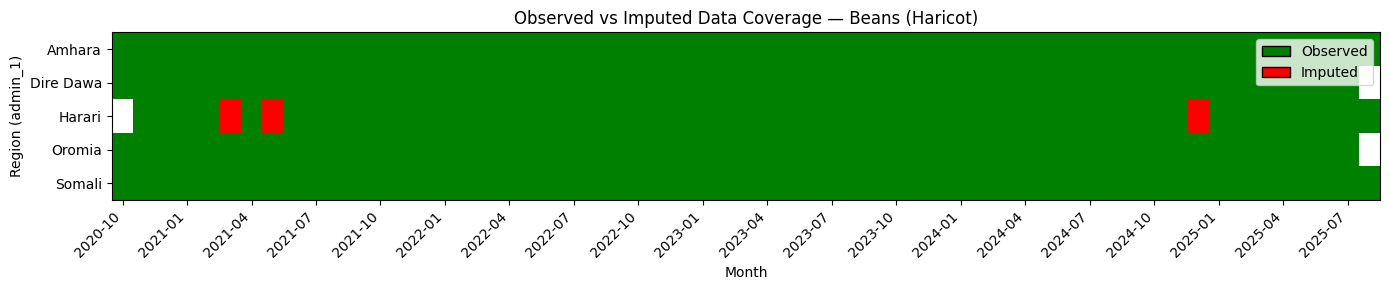

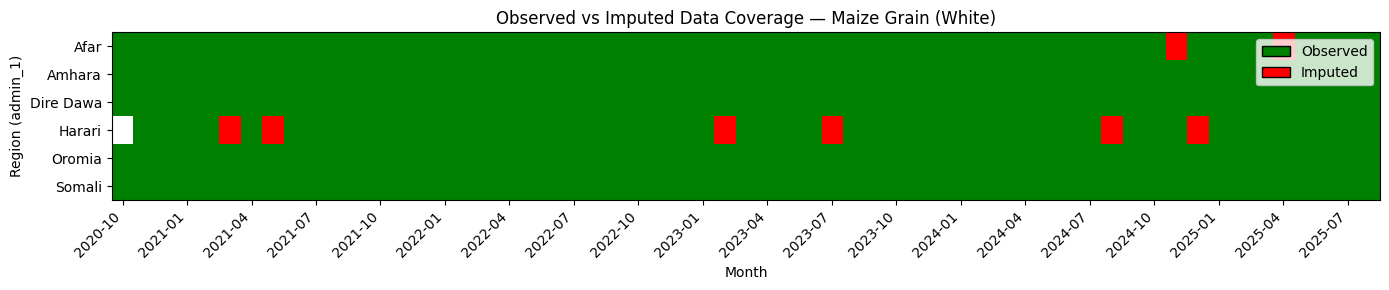

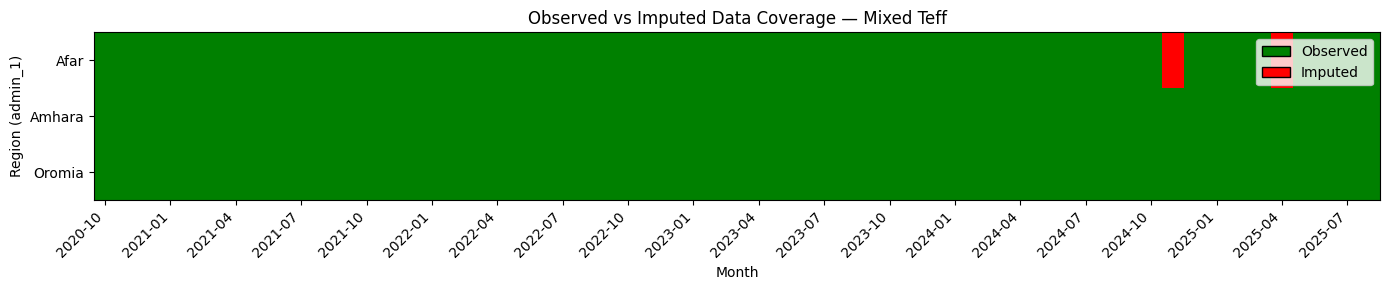

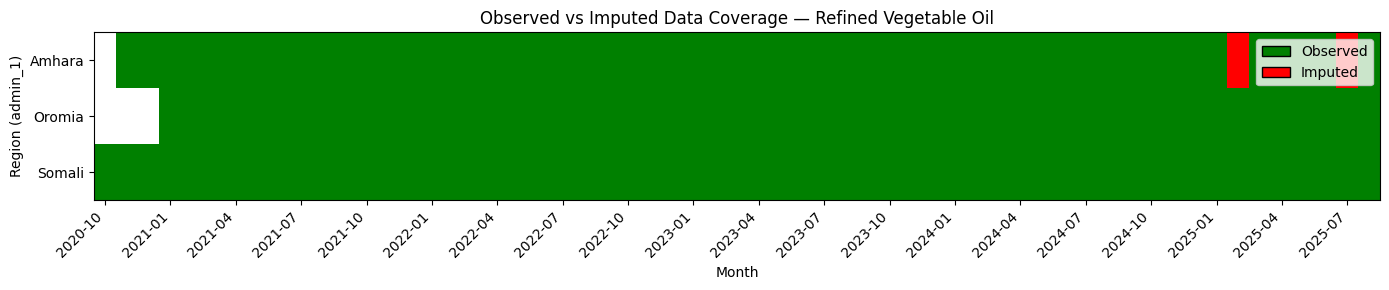

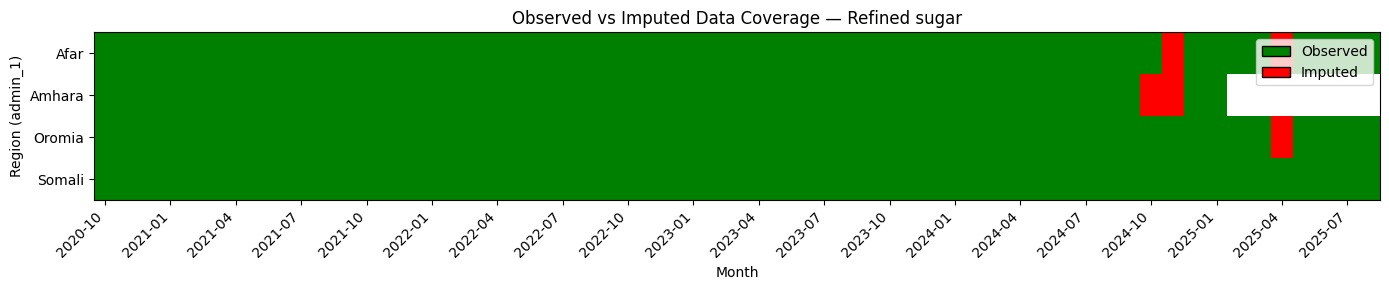

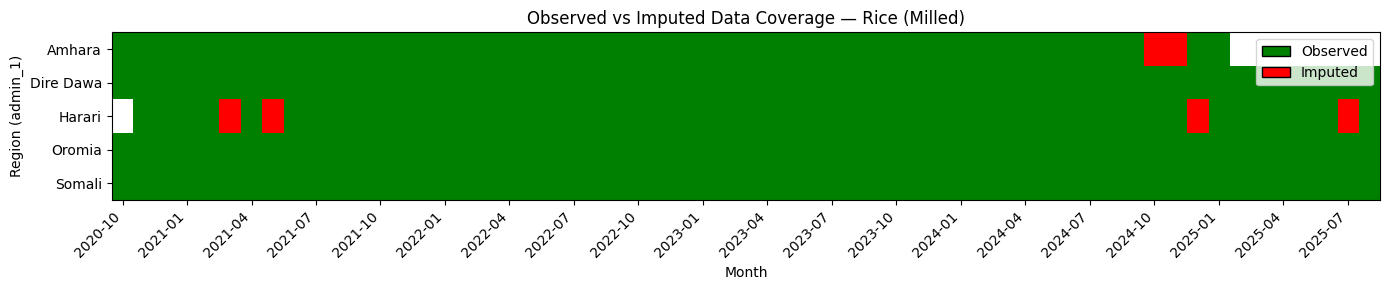

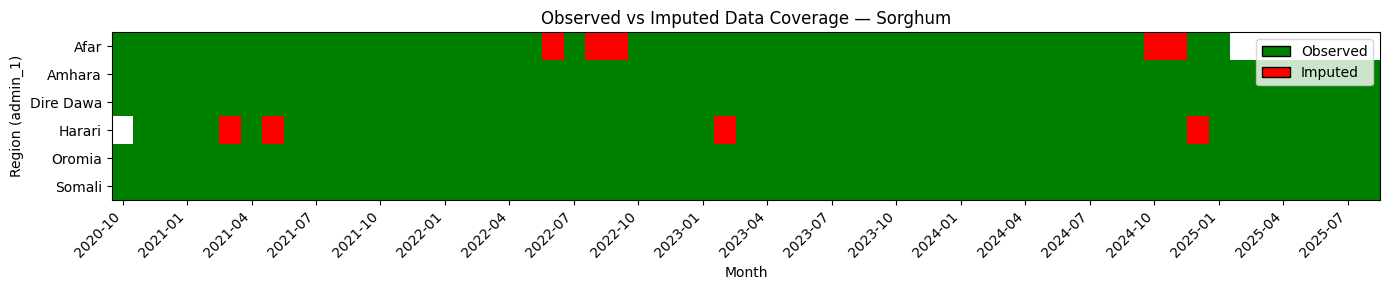

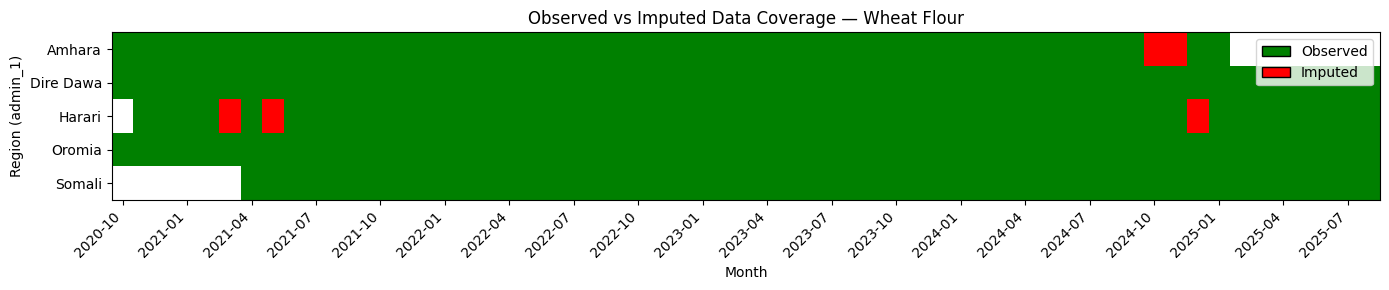

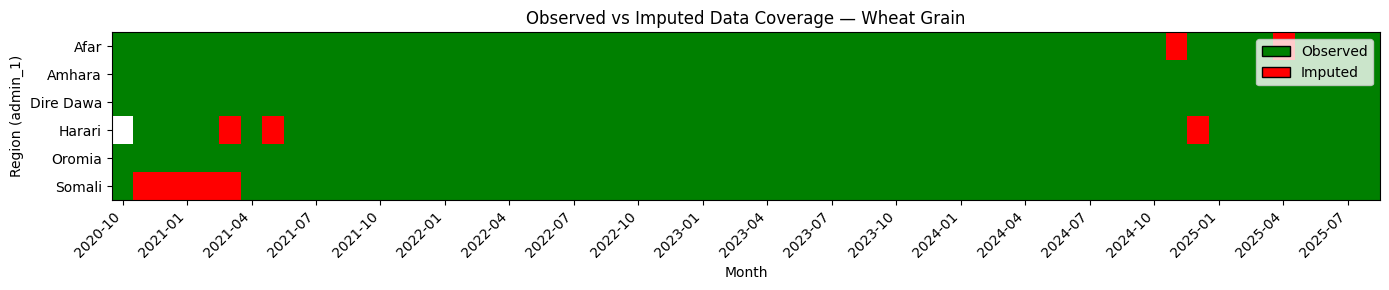

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import os

def plot_coverage_per_product(df):
    """
    Color code:
      - Green = observed
      - Red   = imputed
      - White = missing
    """
    df["month"] = pd.to_datetime(df["month"])
    df["flag"] = np.where(df["impute_method"] == "observed", 1, 2)

    global_start = df["month"].min()
    global_end   = df["month"].max()
    all_months = pd.date_range(global_start, global_end, freq="MS")

    products = sorted(df["product"].unique())

    for prod in products:
        d = df[df["product"] == prod].copy()
        if d.empty:
            continue

        regions = sorted(d["admin_1"].unique())

        grid = np.full((len(regions), len(all_months)), np.nan)
        region_index = {r: i for i, r in enumerate(regions)}
        month_index = {m: i for i, m in enumerate(all_months)}

        for _, row in d.iterrows():
            ri = region_index.get(row["admin_1"])
            mi = month_index.get(row["month"])
            if ri is not None and mi is not None:
                grid[ri, mi] = row["flag"]

        cmap = ListedColormap(["green", "red"])
        grid_masked = np.ma.masked_invalid(grid)
        cmap.set_bad("white")

        fig_height = max(3, 0.4 * len(regions))
        fig, ax = plt.subplots(figsize=(14, fig_height))

        ax.imshow(grid_masked, aspect="auto", cmap=cmap, interpolation="none")
        ax.set_yticks(range(len(regions)))
        ax.set_yticklabels(regions)

        step = max(1, len(all_months) // 15)
        tick_locs = np.arange(0, len(all_months), step)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(
            [m.strftime("%Y-%m") for m in all_months[tick_locs]],
            rotation=45, ha="right"
        )

        ax.set_xlabel("Month")
        ax.set_ylabel("Region (admin_1)")
        ax.set_title(f"Observed vs Imputed Data Coverage — {prod}")

        legend_elements = [
            Patch(facecolor="green", edgecolor="black", label="Observed"),
            Patch(facecolor="red", edgecolor="black", label="Imputed"),
        ]
        ax.legend(handles=legend_elements, loc="upper right")

        plt.tight_layout()
        plt.show()


plot_coverage_per_product(df)



In [ ]:
for (a,p), g in df.groupby(['admin_1','product']):
    plt.figure()
    plt.plot(g['month'], g['value_imputed'], label='Imputed/Observed')
    plt.scatter(g.loc[g['impute_method']=='observed','month'],
                g.loc[g['impute_method']=='observed','value_imputed'],
                color='red', s=10, label='Observed')
    plt.title(f'{a} – {p}')
    plt.legend()
    plt.show()


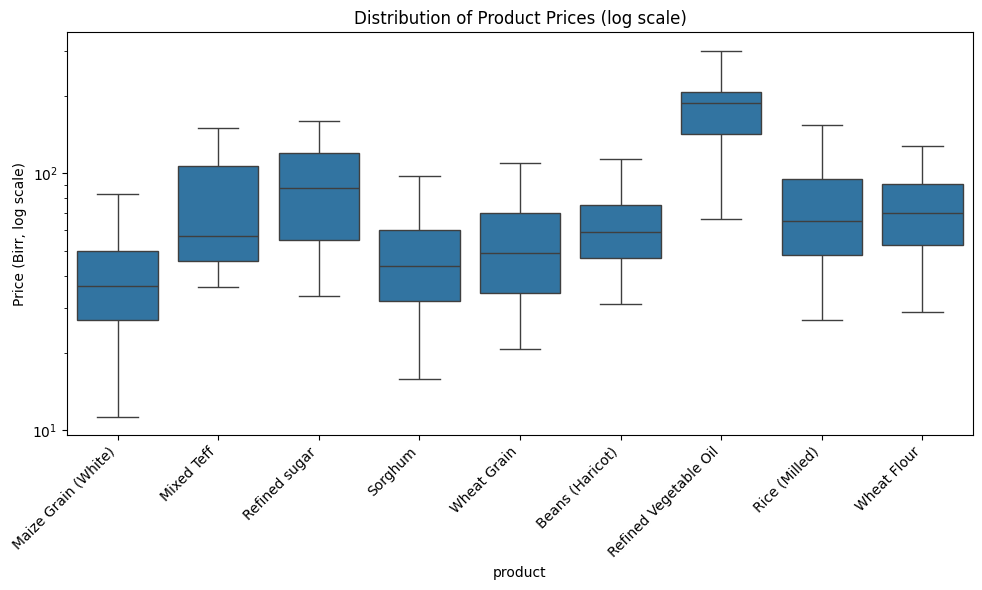

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="product", y="value_imputed", showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.yscale("log")
plt.title("Distribution of Product Prices (log scale)")
plt.ylabel("Price (Birr, log scale)")
plt.tight_layout()
plt.show()

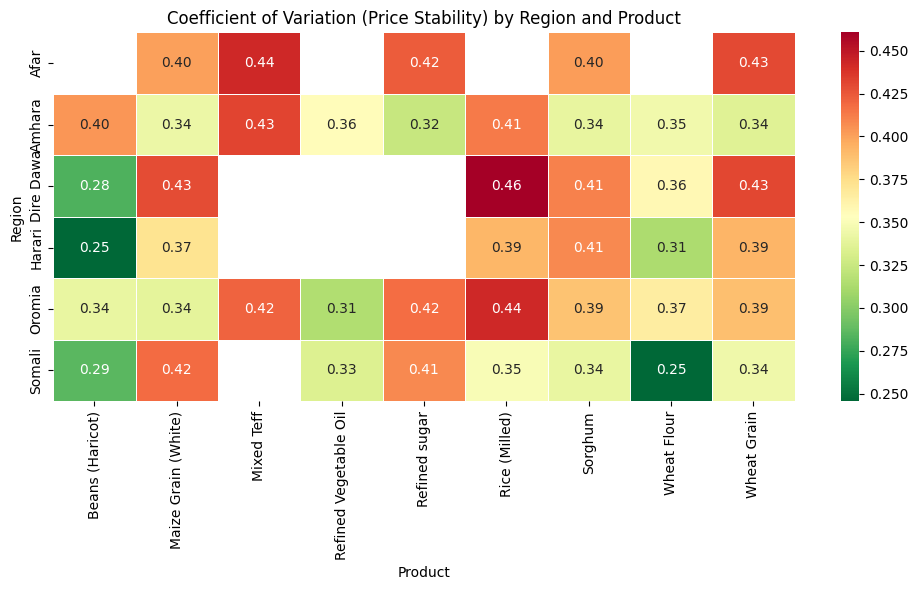

In [ ]:
stability = (
    df.groupby(["admin_1", "product"])
          .agg(
              mean_price = ("value_imputed", "mean"),
              std_price  = ("value_imputed", "std"),
              cv_price   = ("value_imputed", lambda x: x.std() / x.mean()),
              mad_price  = ("value_imputed", lambda x: (abs(x - x.median())).median())
          )
          .reset_index()
)

stability = stability.dropna(subset=["cv_price"])

pivot_cv = stability.pivot(index="admin_1", columns="product", values="cv_price")

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_cv,
    cmap="RdYlGn_r",  # red=high volatility, green=stable
    annot=True,
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Coefficient of Variation (Price Stability) by Region and Product")
plt.xlabel("Product")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

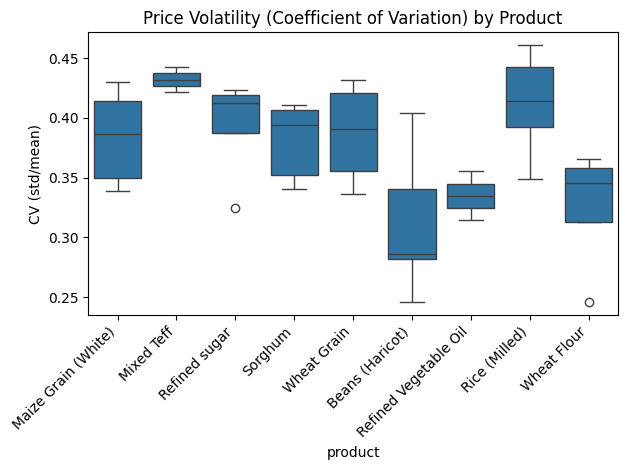

In [ ]:
var_summary = (
    df.groupby(["admin_1", "product"], observed=False)["value_imputed"]
      .agg(["mean", "std", "count"])
      .assign(cv=lambda d: d["std"]/d["mean"])
      .reset_index()
)

var_summary = var_summary[var_summary["count"] > 12]  # ignore too short series
sns.boxplot(data=var_summary, x="product", y="cv")
plt.xticks(rotation=45, ha="right")
plt.title("Price Volatility (Coefficient of Variation) by Product")
plt.ylabel("CV (std/mean)")
plt.tight_layout()
plt.show()


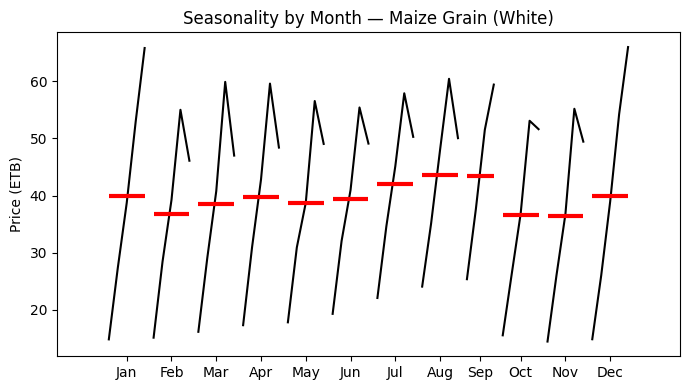

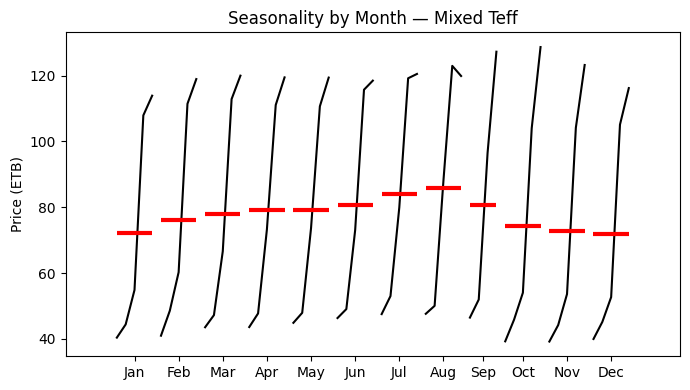

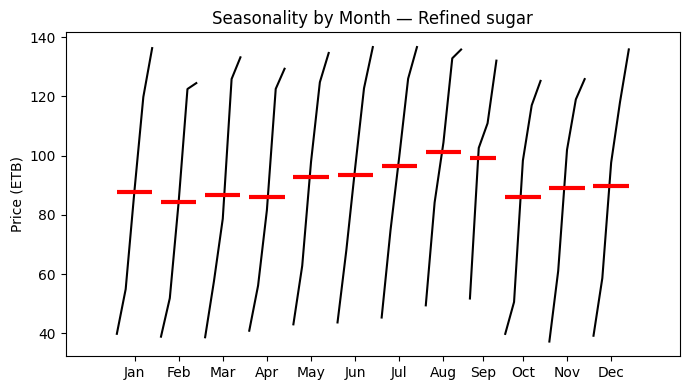

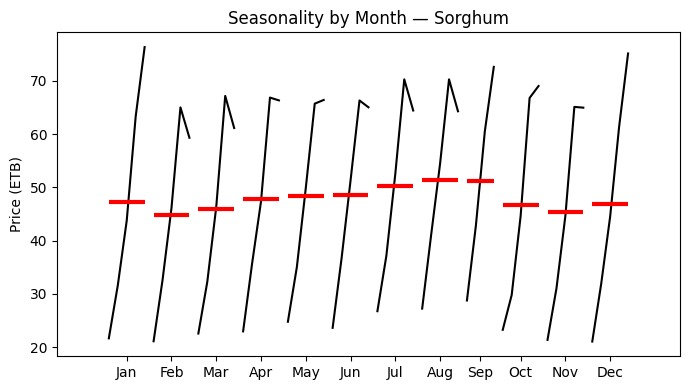

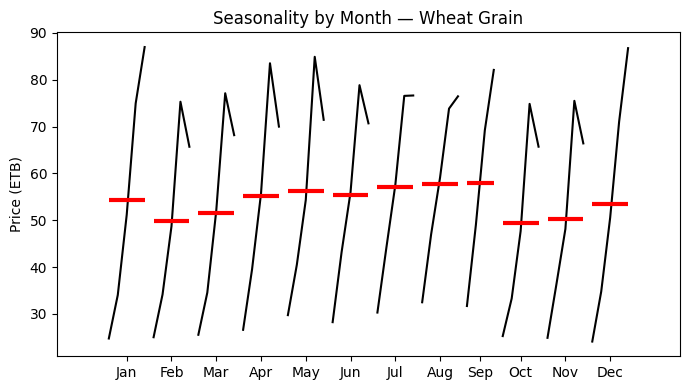

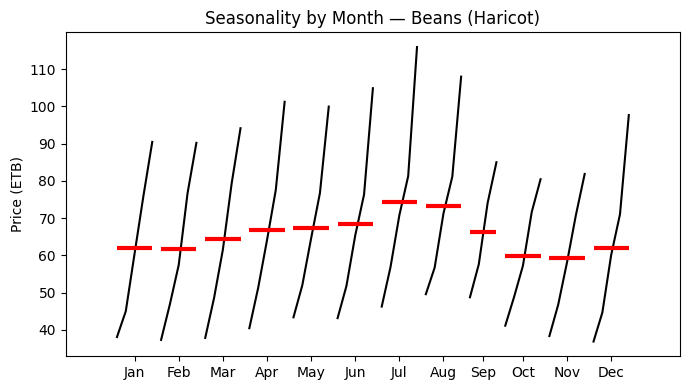

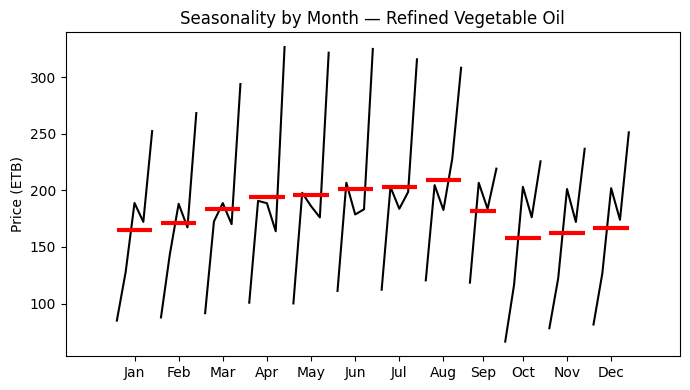

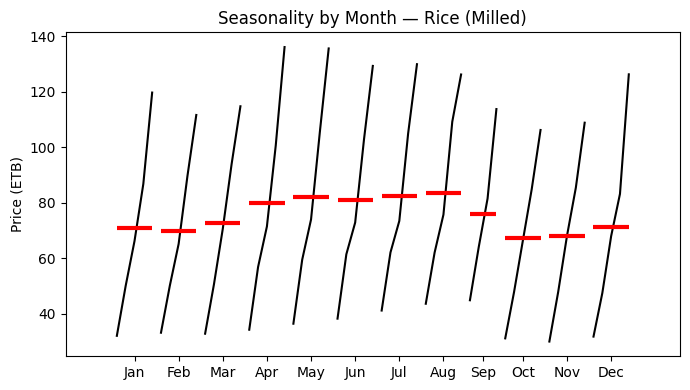

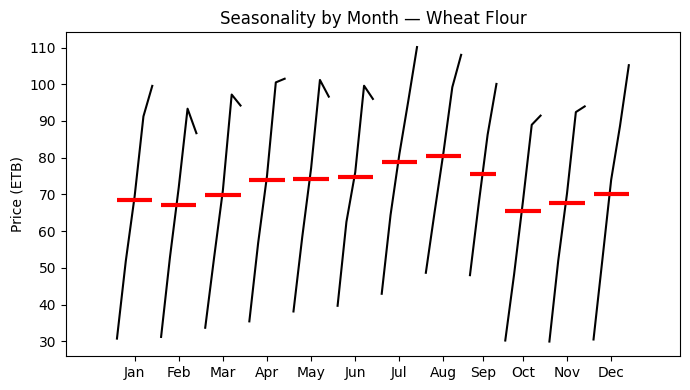

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot

products = [
    'Maize Grain (White)', 'Mixed Teff', 'Refined sugar', 'Sorghum',
    'Wheat Grain', 'Beans (Haricot)', 'Refined Vegetable Oil',
    'Rice (Milled)', 'Wheat Flour'
]

for p in products:
    d = df[df["product"] == p]
    if d.empty:
        continue
    s = (
        d.set_index("month")["value_imputed"]
         .resample("ME").mean()
         .dropna()
    )
    fig, ax = plt.subplots(figsize=(7, 4))
    month_plot(s, ax=ax, ylabel="Price (ETB)")
    ax.set_title(f"Seasonality by Month — {p}")
    plt.tight_layout()
    plt.show()


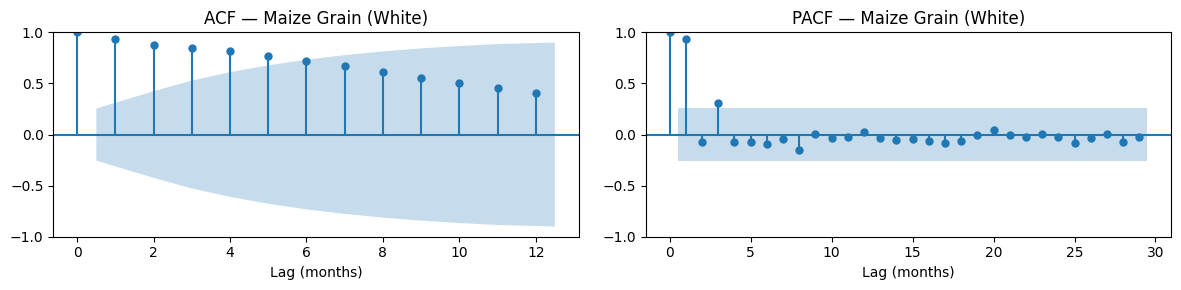

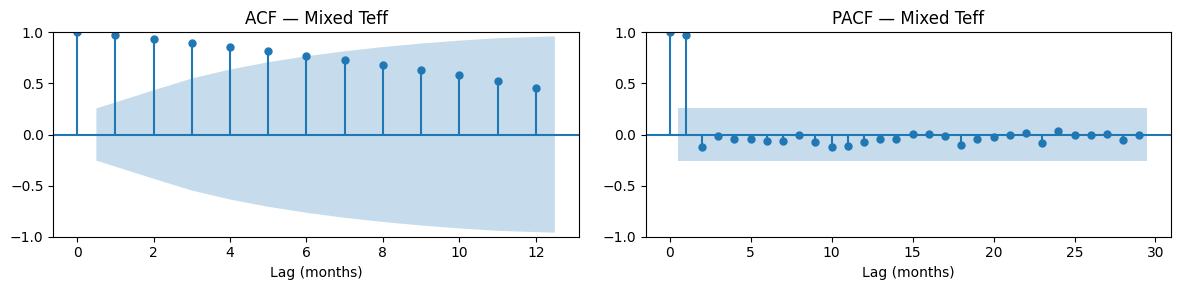

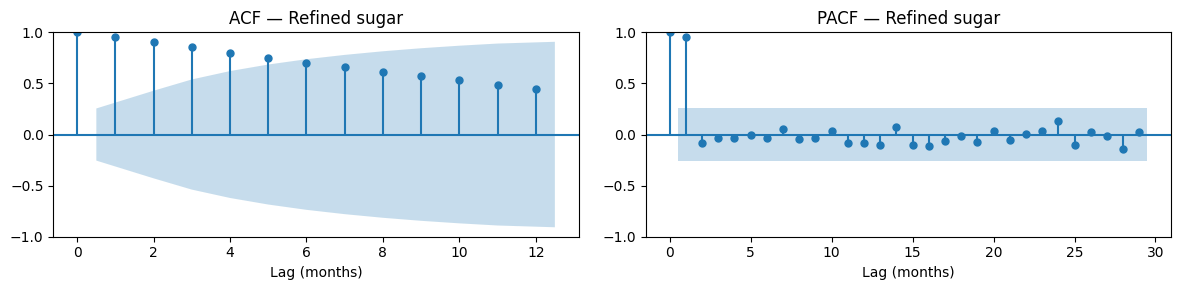

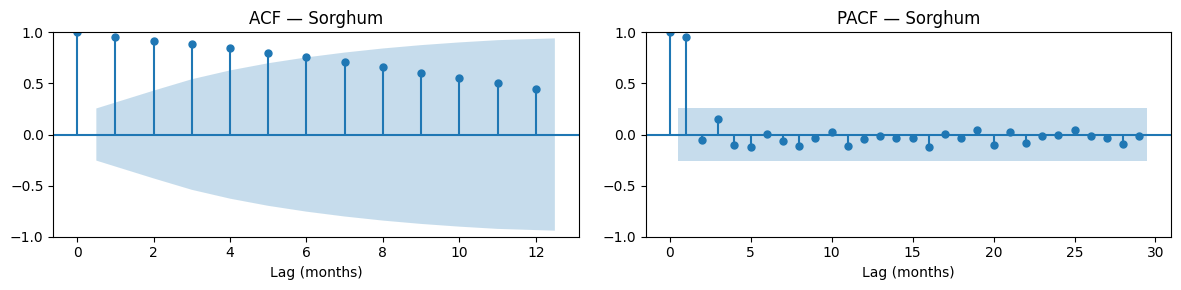

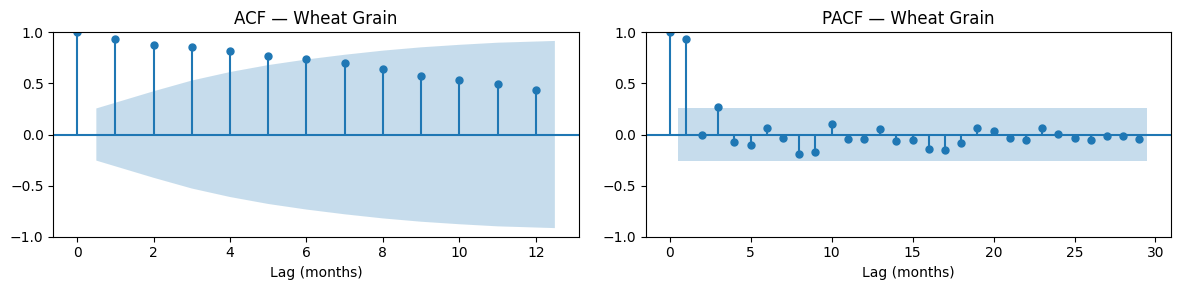

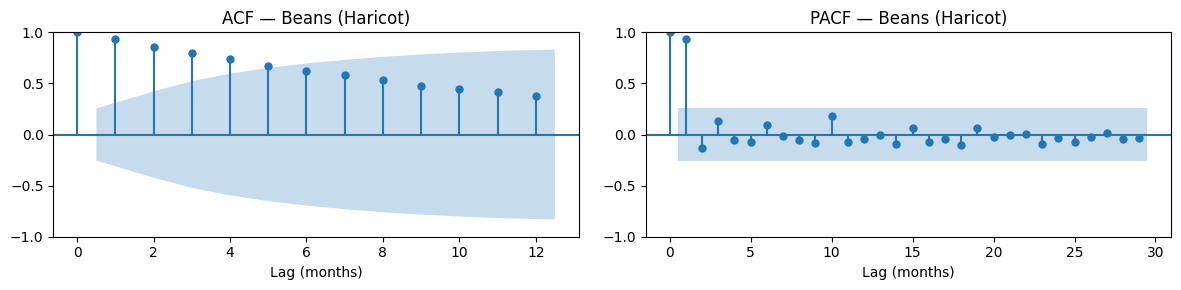

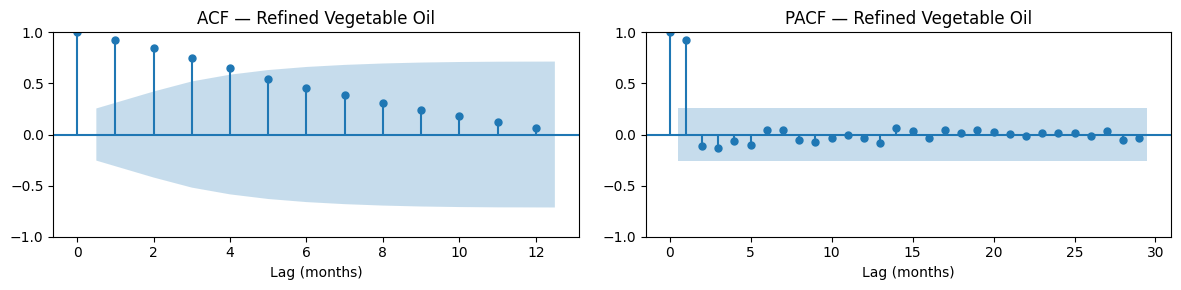

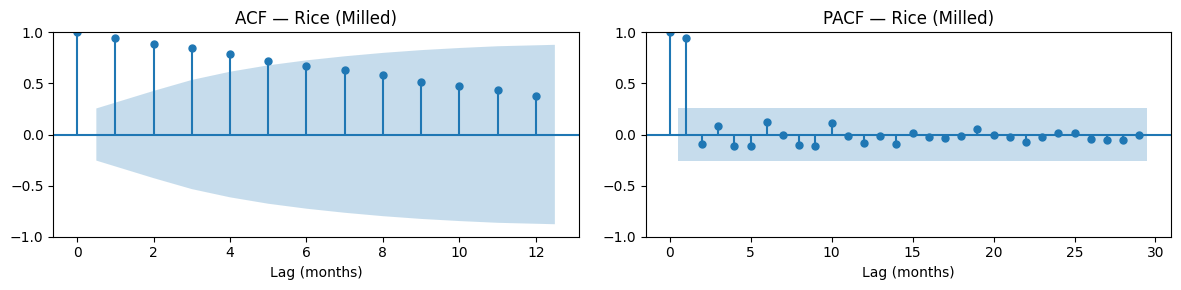

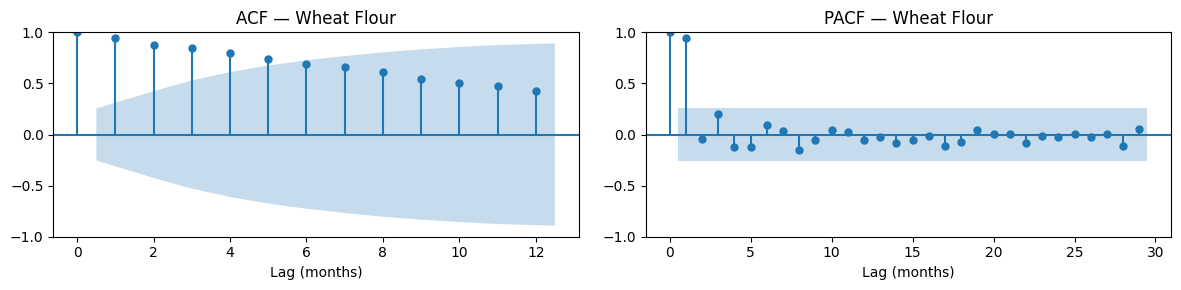

In [ ]:
# Autocorrelation analysis of df['y'] (df already has a DatetimeIndex)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for p in products:
    d = df[df["product"] == p]
    if d.empty:
        continue

    # Ensure datetime, sort, and build a monthly series averaged across regions
    d = d.copy()
    d["month"] = pd.to_datetime(d["month"], errors="coerce")
    s = (
        d.set_index("month")["value_imputed"]
         .sort_index()
         .resample("ME")
         .mean()
         .dropna()
    )

    if len(s) < 3:
        continue

    # Choose sensible lag cap
    nlags = min(12, len(s) - 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    plot_acf(s, lags=nlags, ax=ax1, title=f"ACF — {p}", fft=True, alpha=0.05)
    plot_pacf(s, lags=min(29, len(s)-1), ax=ax2, title=f"PACF — {p}", method="ywm")
    for ax in (ax1, ax2):
        ax.set_xlabel("Lag (months)")
    plt.tight_layout()
    plt.show()


# Feature engineering and model optimization

Lag Features: Prices today often depend on prices in the past — the model can’t infer that automatically from timestamps, so we explicitly provide recent values.

* lag 1 = 1 month
* lag 3 = 3 months
* lag 6 = 6 months

Rolling statistics: Beyond single past points, we want the model to know recent trend and volatility.
* roll_mean_3 = mean of previous 3 months
* roll_std_3 = standard deviation of previous 3 months
* roll_mean_6 = mean of previous 6 months

Seasonal encoding: This gives two coordinates on the unit circle — January and December are now close again. Models can then learn patterns like “prices rise around harvest season” continuously across years.

In [ ]:
import os
os.chdir('/Users/nataschajademinnitt/Documents/5_data/food_security/')

import numpy as np
import pandas as pd
import warnings

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from etl.staples_model_core import (
    impute_features,
    build_features,
    encode_ids,
    pick_features,
    time_split,
    tune_xgb,
    fit_xgb_compat,
    smape,
    rmse,
    TEST_HORIZON_MONTHS,
    N_TRIALS,
    SEED,
)

# ============================== RUN PIPELINE ===============================
# pipeline.py
PARQUET_PATH = "data/processed/ethiopia_foodprices_model_panel.parquet"
panel = pd.read_parquet(PARQUET_PATH)

print("Top-level columns:", list(panel.columns))
assert "rfh_month" in panel.columns or True

# Feature engineering
staples = impute_features(panel)
df_feat = build_features(staples)
df_feat = encode_ids(df_feat)
df_feat = df_feat.sort_values(["month", "admin_1", "product"]).reset_index(drop=True)
feats = pick_features(df_feat)
df_feat[feats] = df_feat[feats].apply(pd.to_numeric, errors="coerce").astype("float32")

# Split
# Split
train_df, test_df = time_split(df_feat, horizon=TEST_HORIZON_MONTHS)
X_train, X_test = train_df[feats], test_df[feats]
y_train_log = np.log1p(train_df["y"])
y_test_true = test_df["y"].to_numpy()

# --- NEW: require at least 12 months of history per (admin_1, product) ---

# How many distinct months of history do we have in the *training* period
hist_month_counts = (
    train_df
    .groupby(["admin_1", "product"])["month"]
    .nunique()
    .rename("n_hist_months")
    .reset_index()
)

# Attach this to the test set
test_df = test_df.merge(hist_month_counts,
                        on=["admin_1", "product"],
                        how="left")

# Flag whether we have ≥ 12 months of history
test_df["has_12m_hist"] = test_df["n_hist_months"].fillna(0) >= 12


# Tune & fit
print(f"Tuning global model ({N_TRIALS} trials)…")
best_params = tune_xgb(X_train, y_train_log, n_trials=N_TRIALS, seed=SEED)

last_train_m = train_df["month"].max()
val_cut = (last_train_m.to_period("M") - 2).to_timestamp()
val_mask = train_df["month"] >= val_cut
X_tr_es, y_tr_es = X_train[~val_mask], y_train_log[~val_mask]
X_va_es, y_va_es = X_train[val_mask],  y_train_log[val_mask]
if len(X_va_es) == 0:
    X_tr_es, y_tr_es = X_train, y_train_log
    X_va_es = y_va_es = None

final_model = fit_xgb_compat(
    best_params,
    X_tr_es,
    y_tr_es,
    X_va_es,
    y_va_es,
    early_rounds=200,
)

y_pred_test = np.expm1(final_model.predict(X_test))

# ---- HYBRID correction (per-product ridge on residuals) ----
train_df["y_pred_global"] = np.expm1(final_model.predict(X_train))
train_df["resid"] = train_df["y"] - train_df["y_pred_global"]

hybrid_models = {}
for prod, g in train_df.groupby("product", observed=False):
    if len(g) < 12:
        continue
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=2.0, fit_intercept=True, random_state=SEED)),
    ])
    Xp = g[["y_pred_global"]]  # simple, stable correction feature
    yp = g["resid"]
    pipe.fit(Xp, yp)
    hybrid_models[prod] = pipe

test_df["y_pred_global"] = y_pred_test

def _apply_hybrid(row):
    prod = row["product"]
    if prod not in hybrid_models:
        return row["y_pred_global"]
    Xcorr = pd.DataFrame([[row["y_pred_global"]]], columns=["y_pred_global"])
    corr = float(hybrid_models[prod].predict(Xcorr)[0])
    return row["y_pred_global"] + corr

test_df["y_pred_hybrid"] = test_df.apply(_apply_hybrid, axis=1)

# Any row without at least 12 months of history → no forecast
mask_ok = test_df["has_12m_hist"]
test_df = test_df[mask_ok].copy()
y_test_true = test_df["y"].to_numpy()

# ---- Metrics ----
valid_mask = test_df["y_pred_hybrid"].notna() & test_df["y"].notna()

print("\n=== STAPLES TEST METRICS (Hybrid, only where ≥12 months history) ===")

mae_val = mean_absolute_error(
    test_df.loc[valid_mask, "y"],
    test_df.loc[valid_mask, "y_pred_hybrid"]
)
rmse_val = rmse(
    test_df.loc[valid_mask, "y"],
    test_df.loc[valid_mask, "y_pred_hybrid"]
)
smape_val = smape(
    test_df.loc[valid_mask, "y"],
    test_df.loc[valid_mask, "y_pred_hybrid"]
)

print(f"MAE : {mae_val:,.3f}")
print(f"RMSE: {rmse_val:,.3f}")
print(f"sMAPE: {smape_val:.2f}%")


gg = test_df.loc[
    test_df["y_pred_hybrid"].notna() & test_df["y"].notna(),
    ["product", "y", "y_pred_hybrid"],
]
by_prod = (
    gg.assign(
        abs_err=lambda d: (d["y"] - d["y_pred_hybrid"]).abs(),
        sq_err=lambda d: (d["y"] - d["y_pred_hybrid"]) ** 2,
        denom=lambda d: (d["y"].abs() + d["y_pred_hybrid"].abs() + 1e-9) / 2.0,
        smape_i=lambda d: (d["y_pred_hybrid"] - d["y"]).abs() / d["denom"] * 100.0,
    )
    .groupby("product", observed=False)
    .agg(
        sMAPE=("smape_i", "mean"),
        MAE=("abs_err", "mean"),
        RMSE=("sq_err", lambda s: float(np.sqrt(s.mean()))),
        N=("y", "size"),
    )
    .reset_index()
    .sort_values("sMAPE", ascending=False)
)
print("\nWorst staples by sMAPE:")
print(by_prod.head(10).to_string(index=False))


/Users/nataschajademinnitt/mamba/envs/foodsec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/nataschajademinnitt/Documents/5_data/food_security/etl/staples_model_core.py:164: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("admin_1", group_keys=False)[c]
/var/folders/z1/szmsj4mj2_jgj9dx7p3cz92w0000gn/T/ipykernel_19005/1299068213.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["admin_1", "product

Top-level columns: ['month', 'admin_1', 'product', 'unit', 'value_mean', 'value_median', 'n_obs', 'value_orig', 'value_imputed', 'impute_method', 'fao_category', 'fao_food_price_index', 'fao_category_index', 'Events', 'Fatalities', 'acled_missing', 'rfh_month', 'rfh_avg_month', 'rfq_month', 'rain_anom_pct', 'ptm_severity', 'population_2023', 'fx_official_etb_per_usd']
[impute_features] columns at entry: ['month', 'admin_1', 'product', 'unit', 'value_mean', 'value_median', 'n_obs', 'value_orig', 'value_imputed', 'impute_method', 'fao_category', 'fao_food_price_index', 'fao_category_index', 'Events', 'Fatalities', 'acled_missing', 'rfh_month', 'rfh_avg_month', 'rfq_month', 'rain_anom_pct', 'ptm_severity', 'population_2023', 'fx_official_etb_per_usd']
Tuning global model (40 trials)…


[I 2025-11-05 14:18:01,039] Trial 0 finished with value: 8.259176656755688 and parameters: {'n_estimators': 1452, 'learning_rate': 0.1231599491871566, 'max_depth': 3, 'min_child_weight': 0.011614074940612243, 'subsample': 0.7452579397986149, 'colsample_bytree': 0.6008043919669491, 'gamma': 0.5298032290476823, 'reg_alpha': 7.991448259616007e-07, 'reg_lambda': 5.209712417254729e-06}. Best is trial 0 with value: 8.259176656755688.
[I 2025-11-05 14:18:04,645] Trial 1 finished with value: 8.994069015175418 and parameters: {'n_estimators': 1615, 'learning_rate': 0.060610121588306025, 'max_depth': 12, 'min_child_weight': 8.030501502896309, 'subsample': 0.7195897268500866, 'colsample_bytree': 0.6264627884543905, 'gamma': 1.7601551623070582, 'reg_alpha': 1.5013819301483175e-05, 'reg_lambda': 0.0003988788680498994}. Best is trial 0 with value: 8.259176656755688.
[I 2025-11-05 14:18:06,414] Trial 2 finished with value: 8.550721509967051 and parameters: {'n_estimators': 1310, 'learning_rate': 0.22

Best sMAPE: 7.573045765144196
Best params: {'n_estimators': 1473, 'learning_rate': 0.1321238745418454, 'max_depth': 10, 'min_child_weight': 0.35839532219807296, 'subsample': 0.8329947018713638, 'colsample_bytree': 0.8643847661422076, 'gamma': 0.3611223624880749, 'reg_alpha': 0.0008421286434614669, 'reg_lambda': 0.026547974689133755}

=== STAPLES TEST METRICS (Hybrid, only where ≥12 months history) ===
MAE : 11.882
RMSE: 27.447
sMAPE: 7.99%

Worst staples by sMAPE:
              product     sMAPE       MAE      RMSE  N
Refined Vegetable Oil 29.724218 81.541939 87.161118 28
      Beans (Haricot)  7.804182  7.083510  9.525777 41
              Sorghum  7.607264  4.332176  6.242281 38
  Maize Grain (White)  5.735070  2.779229  4.115221 49
          Wheat Flour  5.524793  5.551641  8.319131 30
        Rice (Milled)  5.000527  6.311062 10.740309 30
        Refined sugar  4.639117  6.199151  7.982060 18
          Wheat Grain  4.483887  3.259590  4.351950 49
           Mixed Teff  3.607876  4.1